In [1]:
import csv
import gzip
import logomaker
import numpy as np
import pandas as pd
import torch
from captum.attr import DeepLift, Saliency
from captum.attr import visualization as viz
from torch.utils.data import DataLoader
import attributes_functions
from attributes_functions import seqtopad, Chip_test, shift_list, shift, MixtureOfExperts, \
    run_moe, attribute_image_features, returnGradPred, returnGradPredMoE, GetAttShiftSmooth, \
        create_logo, create_motif, seq_to_string

# add smoothGrad/noiseTunnel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/nielseni6/envs/tfbs/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [2]:
# from refactor import ConvNet
# from refactor.dataset import chipseq_dataset
from model import ConvNet
from data import chipseq_dataset

# index 284 has example of GATAA and ATC (looking for TTATC)
# seed 2 highlights GATAA
# seed 3 highlights ATC and GATAA

# index 285 has example of GATAA 
# index 286 has example of TTATC 
# index 287 has example of GATAA 
# index 288 has example of TTATC seed 4 highlights a second ATC for ShiftSmooth that is missed without the method
# index 291 has example of TTATC and shows decent results for ShiftSmooth

seed = 42 # 42 was used for training
set_index = 293

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

data_path = "data/encode"
chipseq_test = Chip_test(
    f"{data_path}/GATA1_K562_GATA-1_USC_B.seq.gz"
)
test_data = chipseq_test.openFile()
test_dataset = chipseq_dataset(test_data)
batchSize = test_dataset.__len__()
print(batchSize)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        
gataa_seq, ttatc_seq = create_motif("GATAA", include_reverse=True)
gataa_seq, ttatc_seq = gataa_seq.to(device), ttatc_seq.to(device)
motifs = ["GATAA", "TTATC"]

# print(data[set_index][:,25:30])
seq = seq_to_string(data[set_index])
print(seq)

# print(motifs[0] in seq)
for motif in motifs:
    if motif in seq:
        print(f"{motif} found")

1000
TGCTACATGAATGGATTAATTCCGTTACAGTGGGAGTGGATTTGTTATCTCGGGAGCAGGTTACTGATAAAAGGATGGGTTCCGCCTCCTTCAGCGCTCTC
GATAA found
TTATC found


## Load Trained Model

In [3]:
# from main import load_model

motifs = ["ARID3A", "FOXM1", "GATA3"]
save_path = "/home/nielseni6/PythonScripts/TFBS/weights/moe"
params = [torch.load(f"{save_path}/best_hyperparameters_{motifs[i]}.pth") for i in range(3)]
# best_hyperparameters = torch.load(f"{save_path}/best_hyperparameters_{0}.pth")
print("best_hyperparameters: ", params)

configs = []
for best_hyperparameters in params:
    config = {
        "nummotif": 16,
        "motiflen": 24,
        "poolType": best_hyperparameters["poolType"],
        "sigmaConv": best_hyperparameters["sigmaConv"],
        "dropprob": best_hyperparameters["dropprob"],
        "learning_rate": best_hyperparameters["learning_rate"],
        "momentum_rate": best_hyperparameters["momentum_rate"],
        "num_features": 32,
        "d_model": 32,
        "num_heads": best_hyperparameters["num_heads"],
        "dim_feedforward": best_hyperparameters["dim_feedforward"],
        "encoder_dropout": best_hyperparameters["encoder_dropout"],
        "num_layers": best_hyperparameters["num_layers"],
    }
    configs.append(config)

individual_models = [ConvNet(configs[i]).to(device) for i in range(len(configs))]

model_paths = [f"{save_path}/best_model_{motifs[i]}.pth" for i in range(len(motifs))]
checkpoints = [torch.load(model_paths[i]) for i in range(len(model_paths))]

nets = [individual_models[i] for i in range(len(individual_models))]
for i, net in enumerate(nets):
    net.load_state_dict(checkpoints[i])



best_hyperparameters:  [{'poolType': 'max', 'neuType': 'hidden', 'dropprob': 0.5, 'sigmaConv': 1.2716139032062706e-05, 'sigmaNeu': 0.0011931486953177214, 'learning_rate': 0.026726429416223375, 'momentum_rate': 0.9624277582387833, 'dim_feedforward': 128, 'num_heads': 2, 'encoder_dropout': 0.45977236927849674, 'num_layers': 1}, {'poolType': 'max', 'neuType': 'nohidden', 'dropprob': 1.0, 'sigmaConv': 7.328923120518368e-07, 'sigmaNeu': 4.978063383534904e-05, 'learning_rate': 0.0016571806788204045, 'momentum_rate': 0.9525742142554656, 'dim_feedforward': 64, 'num_heads': 2, 'encoder_dropout': 0.24001778067924362, 'num_layers': 1}, {'poolType': 'max', 'neuType': 'nohidden', 'dropprob': 1.0, 'sigmaConv': 8.994946940397787e-07, 'sigmaNeu': 0.008615869071958712, 'learning_rate': 0.0024386217769424346, 'momentum_rate': 0.9759534999367341, 'dim_feedforward': 64, 'num_heads': 4, 'encoder_dropout': 0.33707561794552476, 'num_layers': 3}]


In [4]:
import torch.nn as nn
import torch.nn.functional as F

moe_model = MixtureOfExperts(num_experts=len(nets), embedding_size=32).to(device)
checkpoint = torch.load(f"{save_path}/moe_model.pth")
moe_model.load_state_dict(checkpoint)

# Pick net to use for attribution (e.g. nets[0] for ARID3A, nets[1] for FOXM1, nets[2] for GATA3)
net = nets[2]


## Generate Attribution Maps

In [5]:
original_image = np.transpose((data.cpu().detach().numpy()), (0, 1, 2))

saliency = Saliency(net)
grads = saliency.attribute(data)
grads = grads.squeeze().detach().cpu().numpy()

dl = DeepLift(net)
net.zero_grad()
attr_dl = attribute_image_features(dl, data, baselines=data * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (0, 1, 2))

print(grads.shape, attr_dl.shape, original_image.shape)

index = np.random.randint(0, grads.shape[0])
while target[index][0] == 0:
    index = np.random.randint(0, grads.shape[0])
# Good index that includes ATC and GATAA is index = 284
index = set_index

print(index)
grads = grads[index]
original_image = original_image[index]
attr_dl = attr_dl[index]

print("original_image.shape: ", original_image.shape, "data.shape: ", data.shape)
mask = (data[index,:] != 0.25)[0].cpu()
print("mask.shape: ", mask.shape)
image_nopad_ = original_image[:,mask]
shape_nopad = image_nopad_.shape
image_nopad = image_nopad_.reshape(shape_nopad[0], shape_nopad[1], 1)
# grads = grads[:,mask]
# attr_dl = attr_dl[:,mask]
# print("original_image.shape: ", original_image.shape)
shape = original_image.shape

print(grads.shape, attr_dl.shape, original_image.shape)
grads = grads.reshape(shape[0], shape[1], 1)
attr_dl = attr_dl.reshape(shape[0], shape[1], 1)
original_image = original_image.reshape(shape[0], shape[1], 1)
print(grads.shape, attr_dl.shape, original_image.shape)

/home/nielseni6/envs/tfbs/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


(1000, 4, 147) (1000, 4, 147) (1000, 4, 147)
293
original_image.shape:  (4, 147) data.shape:  torch.Size([1000, 4, 147])
mask.shape:  torch.Size([147])
(4, 147) (4, 147) (4, 147)
(4, 147, 1) (4, 147, 1) (4, 147, 1)


/home/nielseni6/envs/tfbs/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


## ShiftSmooth

/tmp/ipykernel_342215/3431617055.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grads = returnGradPred(torch.tensor(data_, dtype = torch.float32).to(device),
/home/nielseni6/PythonScripts/TFBS/attributes_functions.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_np = torch.tensor(x_value)
/home/nielseni6/PythonScripts/TFBS/attributes_functions.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  og_img = torch.tensor(og_img)
/home/nielseni6/PythonScripts/TFBS/attributes_functions.py:209: UserWarning: To copy construct from a

original_image.shape:  (4, 147, 1) dat_nopad.shape:  torch.Size([1, 4, 101]) data_.shape:  torch.Size([1, 4, 147])
tensor([[[0., 0., 1., 0., 1.],
         [1., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0.]]], device='cuda:0')


/home/nielseni6/PythonScripts/TFBS/attributes_functions.py:205: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_np = torch.tensor(x_value)
/home/nielseni6/PythonScripts/TFBS/attributes_functions.py:206: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  og_img = torch.tensor(og_img)
/home/nielseni6/PythonScripts/TFBS/attributes_functions.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  total_gradients = torch.tensor(torch.zeros_like(og_img)).to(device)


(4, 147, 1)


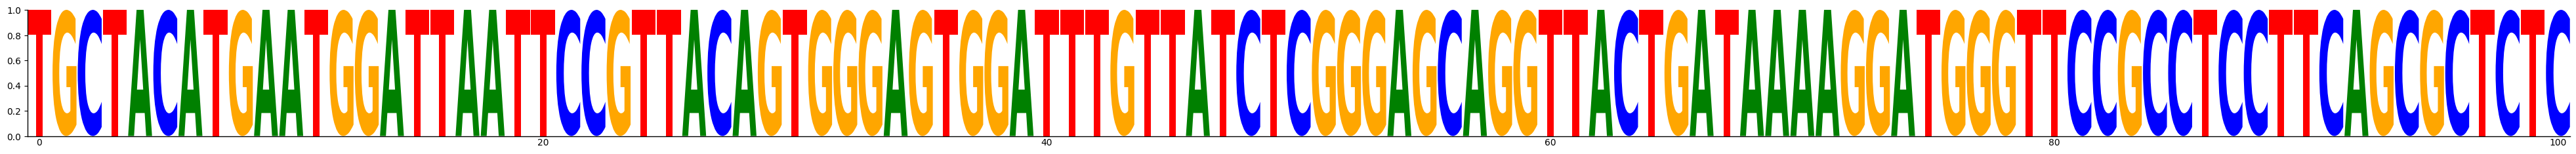

In [6]:
# shp = data[index].unsqueeze(0).shape
# dat = data[index].unsqueeze(0).clone().detach().cpu().numpy()
dat = torch.tensor(np.transpose(original_image, (2, 0, 1)), dtype = torch.float32).to(device)
# dat_pad = torch.tensor(image_nopad_, dtype = torch.float32).to(device)
# print("image_nopad.shape: ", image_nopad.shape, "original_image.shape: ", original_image.shape)
dat_nopad = torch.tensor(np.transpose(image_nopad, (2, 0, 1)), dtype = torch.float32).to(device)
# print("dat_nopad.shape: ", dat_nopad.shape)
shp = dat.shape

############################### Choose Model (Not MoE) ###############################
# Pick net to use for attribution (e.g. nets[0] for ARID3A, nets[1] for FOXM1, nets[2] for GATA3)
net = nets[2]
model = net # this will be cleaned up

########################## SET PARAMETERS FOR ATTRIBUTIONS ##########################
# only show the most important nucleotide
max_only = False 
# absolute value of attribution
magnitude = False 
# only show letters corresponding to actual sequence (will be true for paper results)
original_sequence_only = True 
relu = False
begin_shift = 2
end_shift = 30#20#100
shift_increment = 3#15
#####################################################################################

sequence = original_image if original_sequence_only else 1
data_ = data[index].unsqueeze(0).clone().detach()

################################### SINGLE MODEL ###################################
grads = returnGradPred(torch.tensor(data_, dtype = torch.float32).to(device), 
                       magnitude=magnitude, max_only=max_only, net = model, relu=relu
                       )[0].reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence

attr_shiftsmooth = GetAttShiftSmooth(dat_nopad, nshiftlr=1, magnitude=magnitude, max_only=max_only, 
                                     net = model, mask = mask, og_img = data_, device = device, relu=relu
                                     ).reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence
print("original_image.shape: ", original_image.shape, "dat_nopad.shape: ", dat_nopad.shape, "data_.shape: ", data_.shape)
print(data_[:,:,25:30])
crp_df_original_logo = create_logo(original_image[:,mask], figsize=[50, 2.5])

attr_shiftsmooths = [(GetAttShiftSmooth(dat_nopad, nshiftlr=i, magnitude=magnitude, max_only=max_only, 
                                        net = model, mask = mask, og_img = data_, device = device, relu=relu
                     ).reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence, i) 
                     for i in range(begin_shift, end_shift, shift_increment)]
####################################################################################
#################### MoE Model (individual experts attribution) ####################
datas = [data_.clone().detach() for _ in range(len(nets))]
# output = run_moe(dat, moe_model, nets)
# print(output)
moe_grad = returnGradPredMoE(datas, magnitude=magnitude, max_only=max_only, 
                          moe_model=moe_model, nets=nets, gate_scaling=False, relu=relu
                          )[0]
moe_grads_separate = [(gd.reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence) for gd in moe_grad]
####################################################################################
##################### MoE Model total forward pass attribution #####################
moe_grad = returnGradPredMoE(data_, magnitude=magnitude, max_only=max_only, 
                          moe_model=moe_model, nets=nets, relu=relu
                          )[0].reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence
print(moe_grad.shape)
moe_shiftsmooths = [(GetAttShiftSmooth(dat_nopad, net = nets, nshiftlr=i, magnitude=magnitude, max_only=max_only, 
                     moe_model=moe_model, mask = mask, og_img = data_, device = device, relu=relu)
                     .reshape(shp[1], shp[2], shp[0]).clone().detach().cpu().numpy() * sequence, i) 
                     for i in range(begin_shift, end_shift, shift_increment)]
####################################################################################
# x_np = data[index].unsqueeze(0).clone().detach().cpu().numpy()
# x_np = torch.tensor(x_np, dtype = torch.float32).cuda()
# vanilla_grads = abs(returnGradPred(x_np)[0].reshape(shp[1], shp[2], shp[0]) ** 2).clone().detach().cpu().numpy()


## Plot

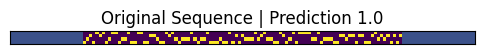

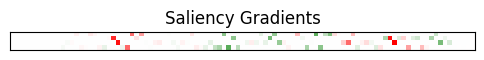

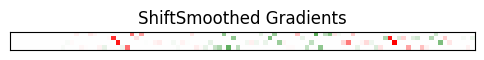

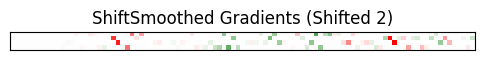

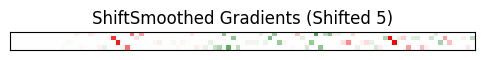

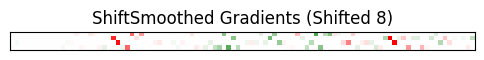

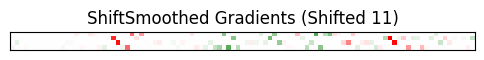

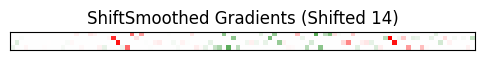

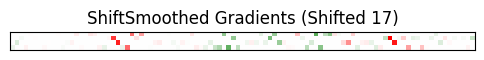

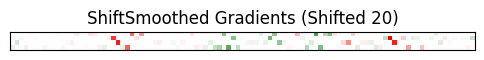

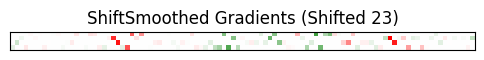

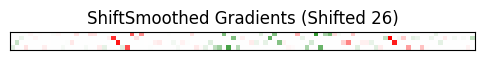

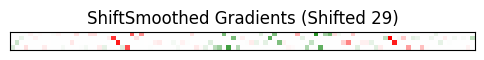

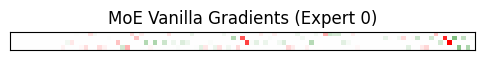

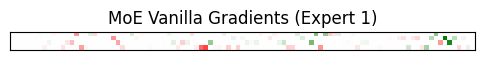

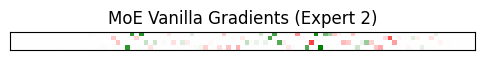

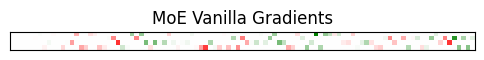

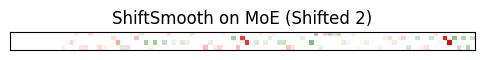

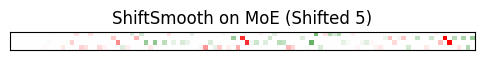

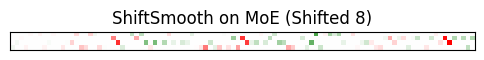

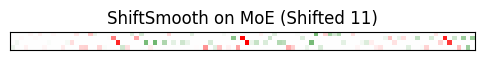

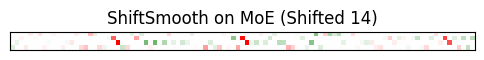

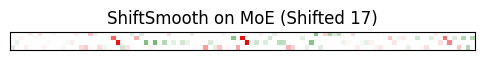

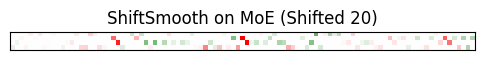

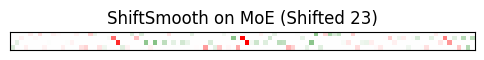

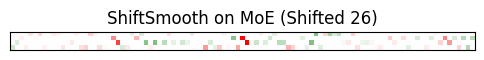

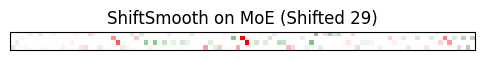

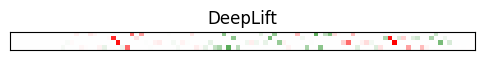

In [7]:
include_pad = False
if include_pad:
    mask[:,:] = True

_ = viz.visualize_image_attr(
    None,
    original_image,
    method="original_image",
    title="Original Sequence | Prediction {}".format(target[index][0]),
)
################################### SINGLE MODEL ###################################
_ = viz.visualize_image_attr(
    grads[:,mask], original_image[:,mask], method="heat_map", sign="all", title="Saliency Gradients"
)

# _ = viz.visualize_image_attr(
#     vanilla_grads, original_image, method="heat_map", sign="all", title="Vanilla Gradients"
# )

_ = viz.visualize_image_attr(
    attr_shiftsmooth[:,mask], original_image[:,mask], method="heat_map", sign="all", title="ShiftSmoothed Gradients"
)

for attr_shiftsmooth2, i in attr_shiftsmooths:
    _ = viz.visualize_image_attr(
        attr_shiftsmooth2[:,mask], original_image[:,mask], method="heat_map", sign="all", title=f"ShiftSmoothed Gradients (Shifted {i})"
    )
# _ = viz.visualize_image_attr(
#     attr_shiftsmooth2, original_image, method="heat_map", sign="all", title="ShiftSmoothed Gradients (Shifted 2)"
# )
####################################################################################

#################### MoE Model (individual experts attribution) ####################

for i, moe_grad_ in enumerate(moe_grads_separate):
    _ = viz.visualize_image_attr(
        moe_grad_[:,mask], original_image[:,mask], method="heat_map", sign="all", title=f"MoE Vanilla Gradients (Expert {i})"
    )
####################################################################################
##################### MoE Model total forward pass attribution #####################
_ = viz.visualize_image_attr(
    moe_grad[:,mask], original_image[:,mask], method="heat_map", sign="all", title="MoE Vanilla Gradients"
)

for moe_shiftsmooth, i in moe_shiftsmooths:
    _ = viz.visualize_image_attr(
        moe_shiftsmooth[:,mask], original_image[:,mask], method="heat_map", sign="all", title=f"ShiftSmooth on MoE (Shifted {i})"
    )
####################################################################################

_ = viz.visualize_image_attr(
    attr_dl[:,mask], original_image[:,mask], method="heat_map", sign="all", title="DeepLift"
)


## Motifs

Original Sequence
Vanilla Gradients


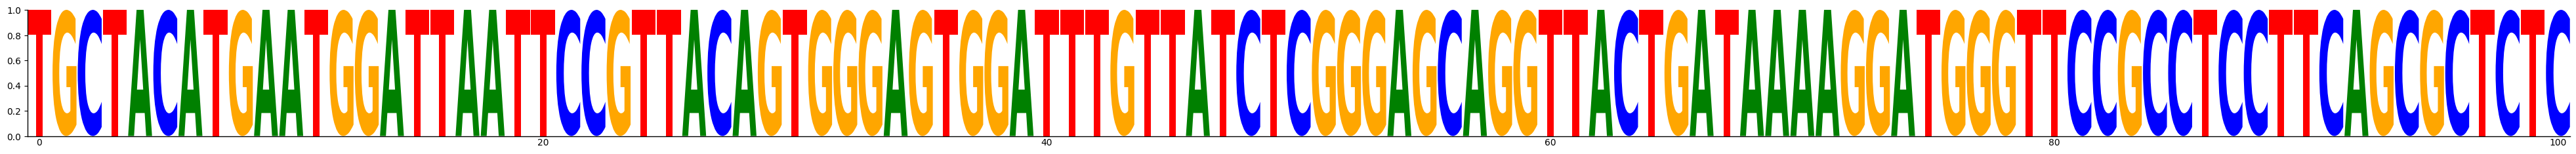

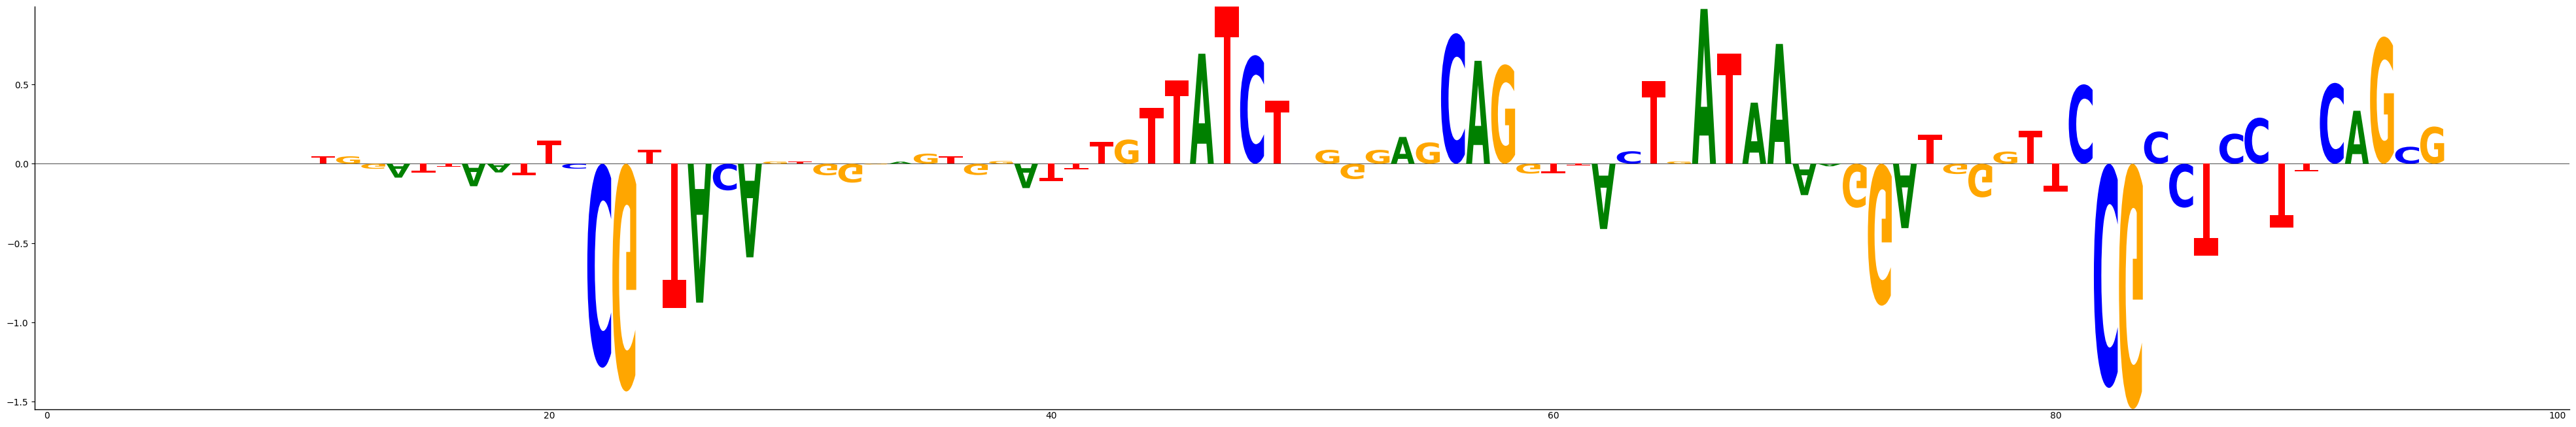

In [8]:
scale_data = False
# Create logos for each dataset
print("Original Sequence")
crp_df_original_logo = create_logo(original_image[:,mask], figsize=[50, 2.5])
print("Vanilla Gradients")
crp_logo = create_logo(grads[:,mask], figsize=[50, 8], scale_data=scale_data)
# print("Vanilla Gradients")
# vg_crp_logo = create_logo(vanilla_grads, figsize=[50, 8], scale_data=True)

ShiftSmoothed Gradients
ShiftSmoothed Gradients (Shifted 2)
ShiftSmoothed Gradients (Shifted 5)
ShiftSmoothed Gradients (Shifted 8)
ShiftSmoothed Gradients (Shifted 11)
ShiftSmoothed Gradients (Shifted 14)
ShiftSmoothed Gradients (Shifted 17)
ShiftSmoothed Gradients (Shifted 20)
ShiftSmoothed Gradients (Shifted 23)
ShiftSmoothed Gradients (Shifted 26)
ShiftSmoothed Gradients (Shifted 29)


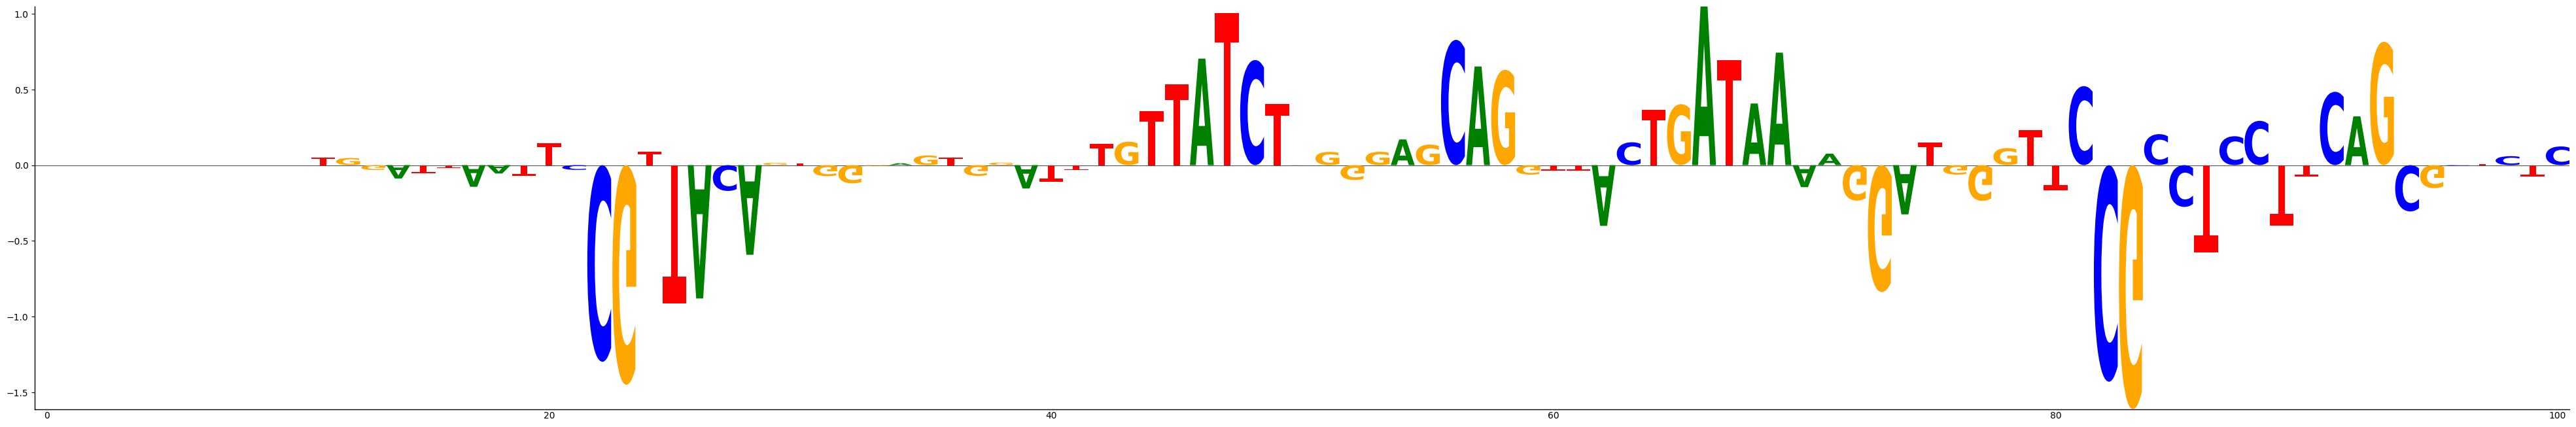

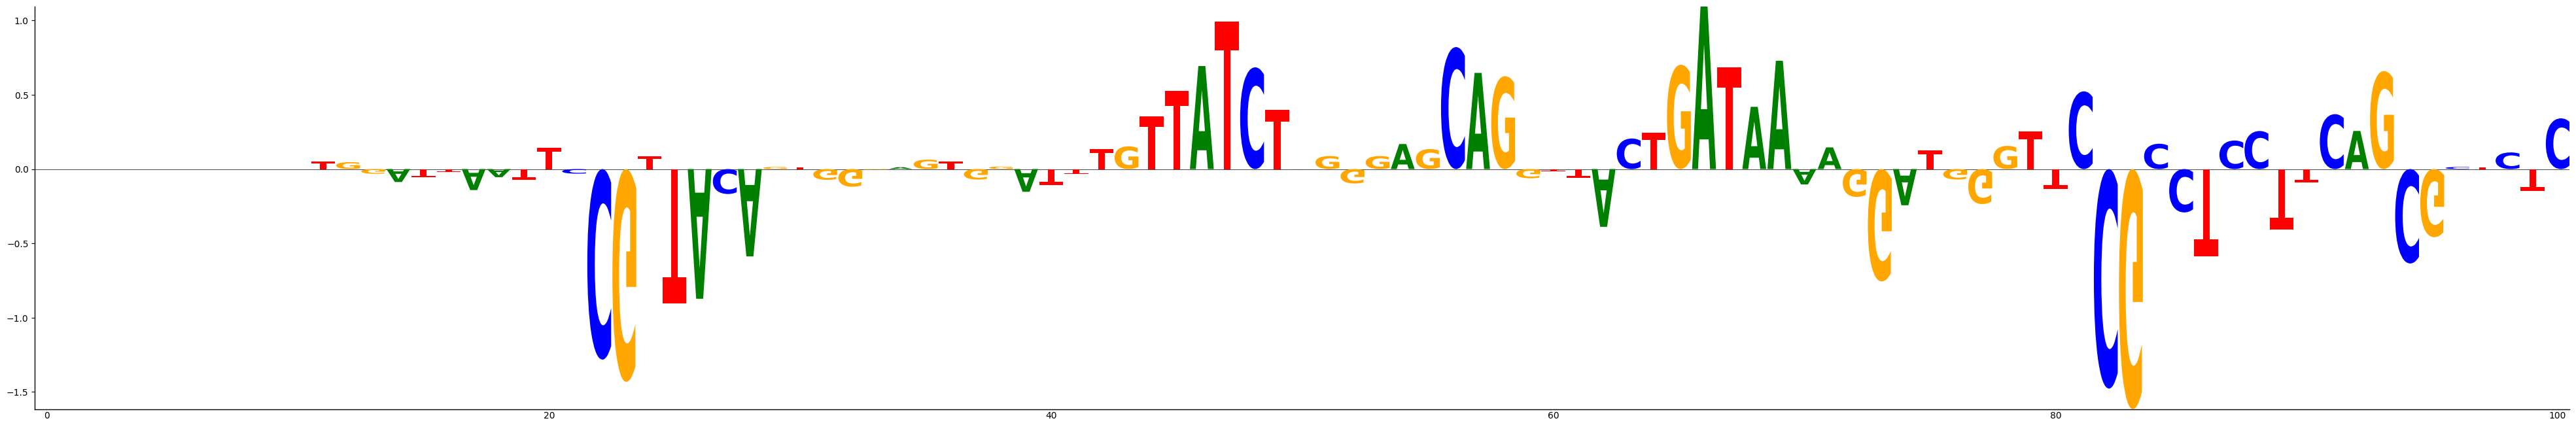

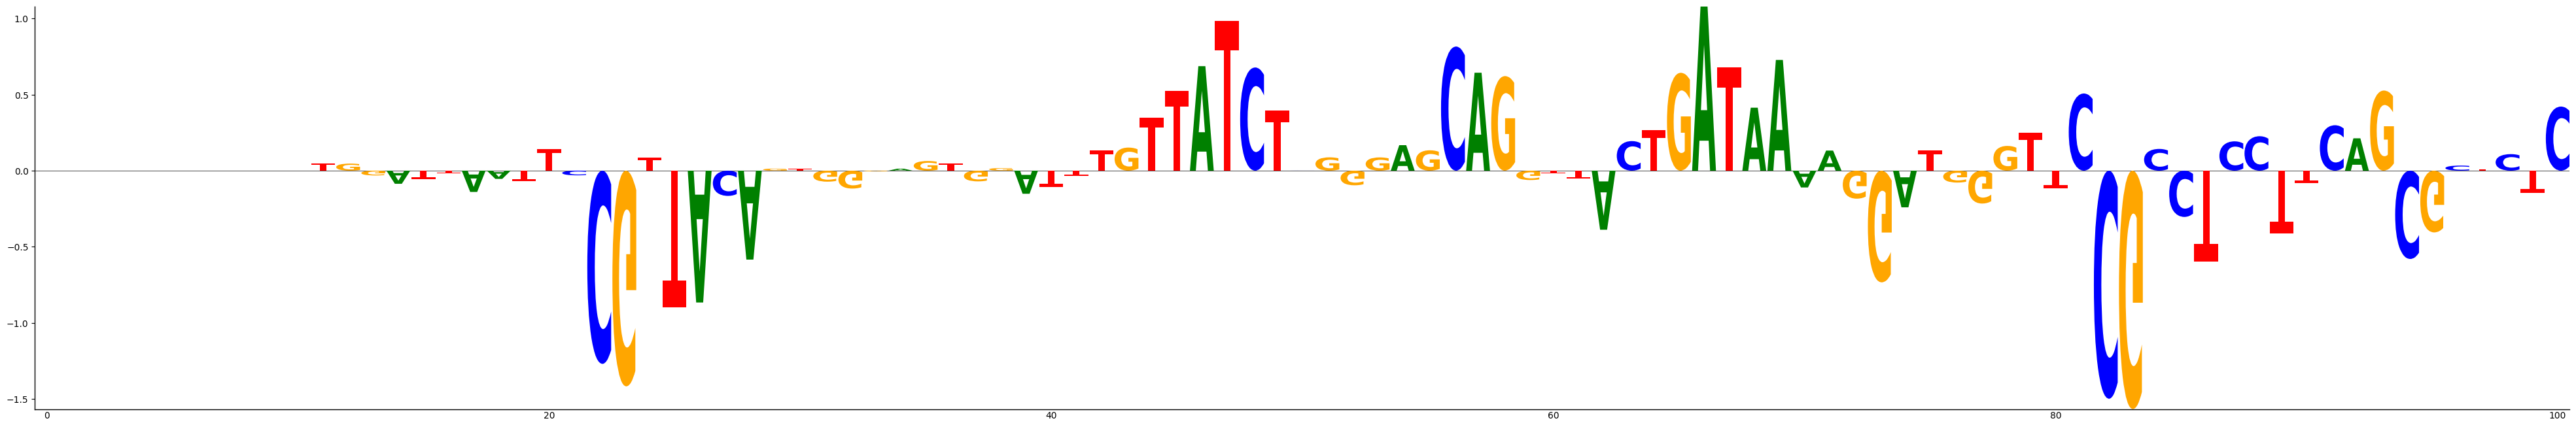

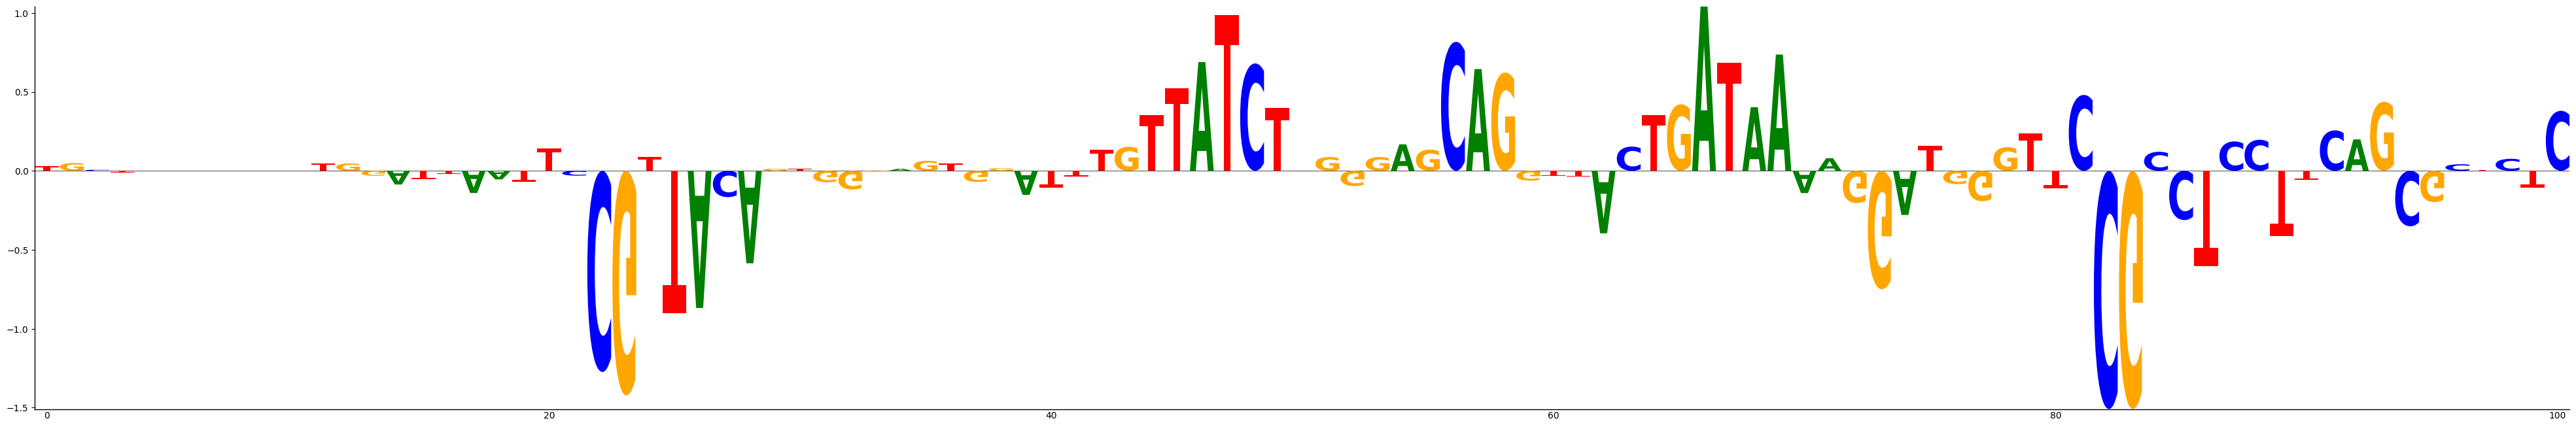

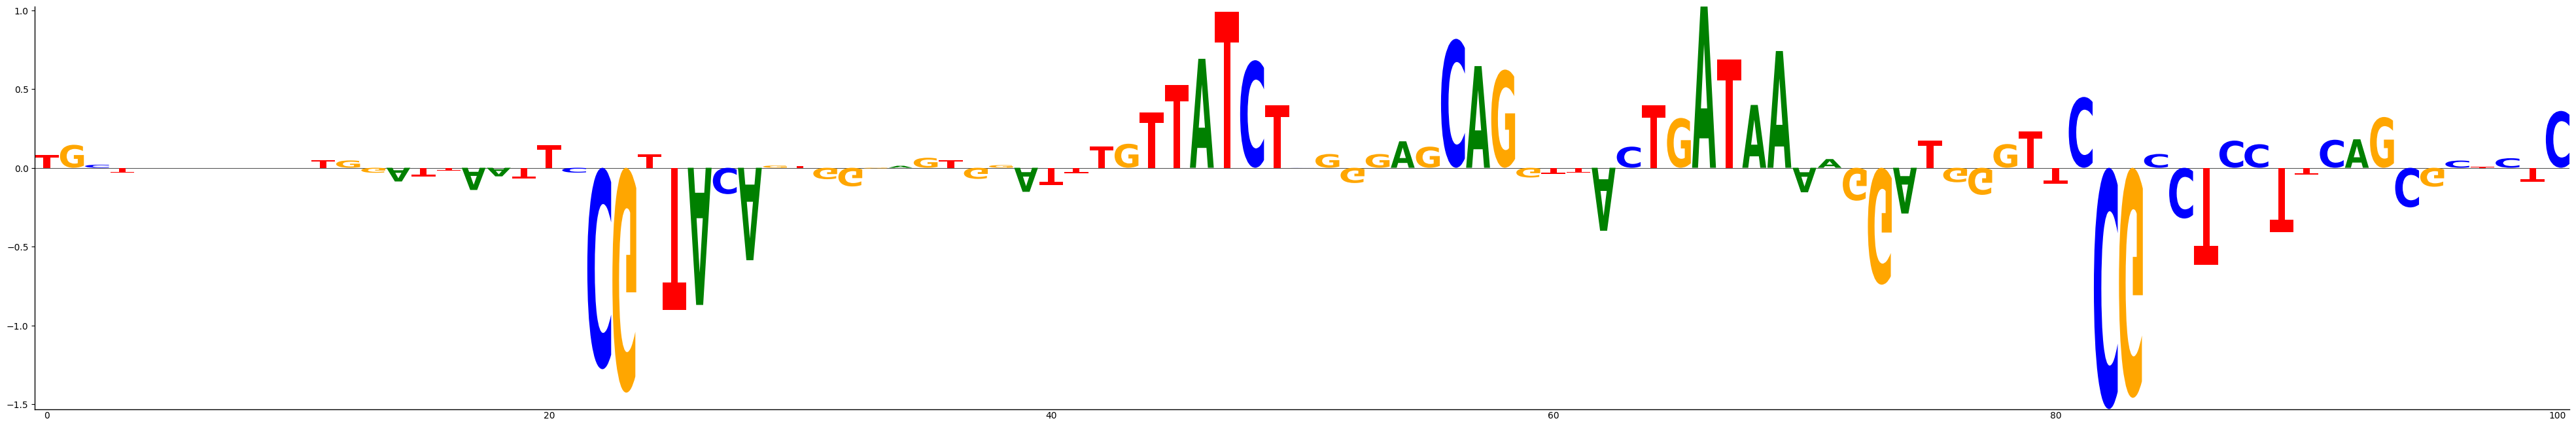

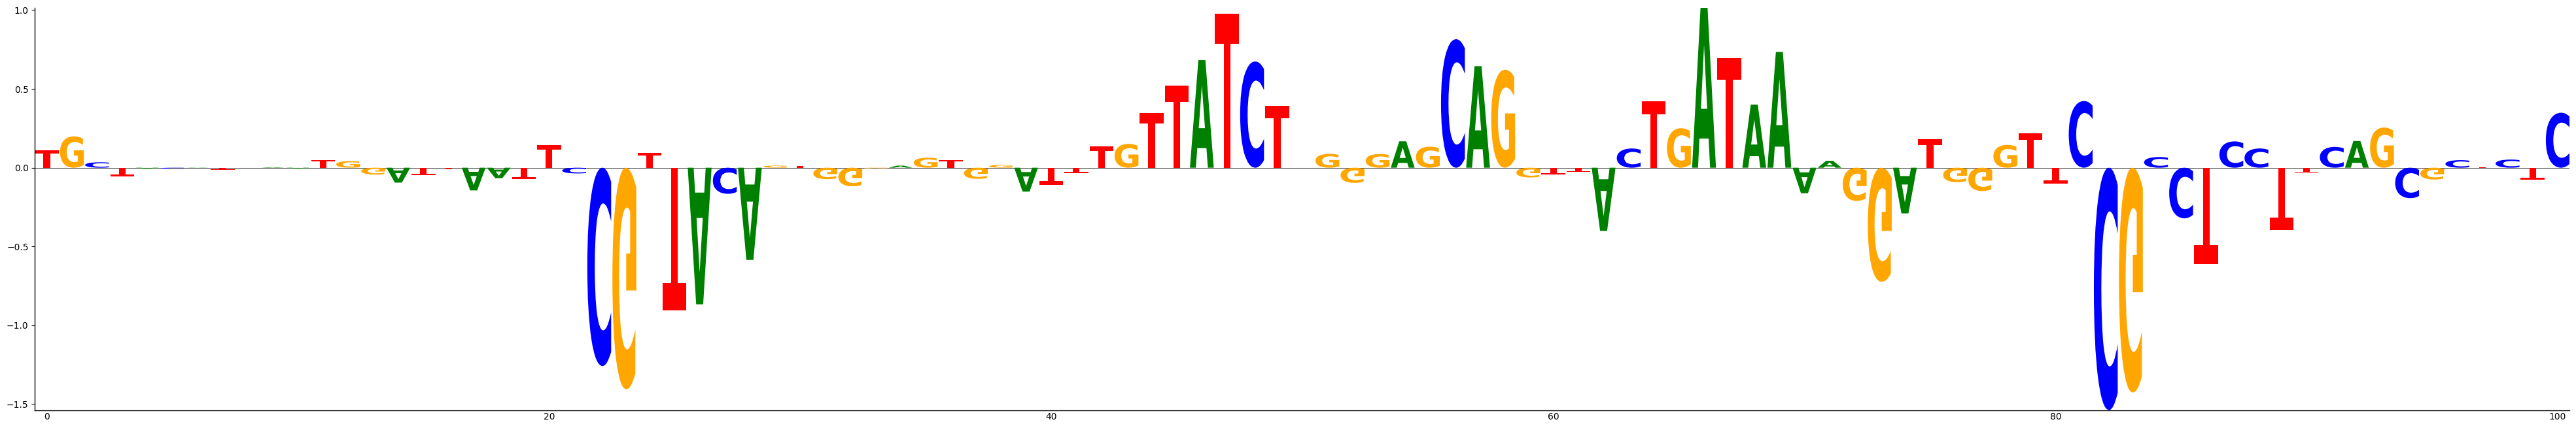

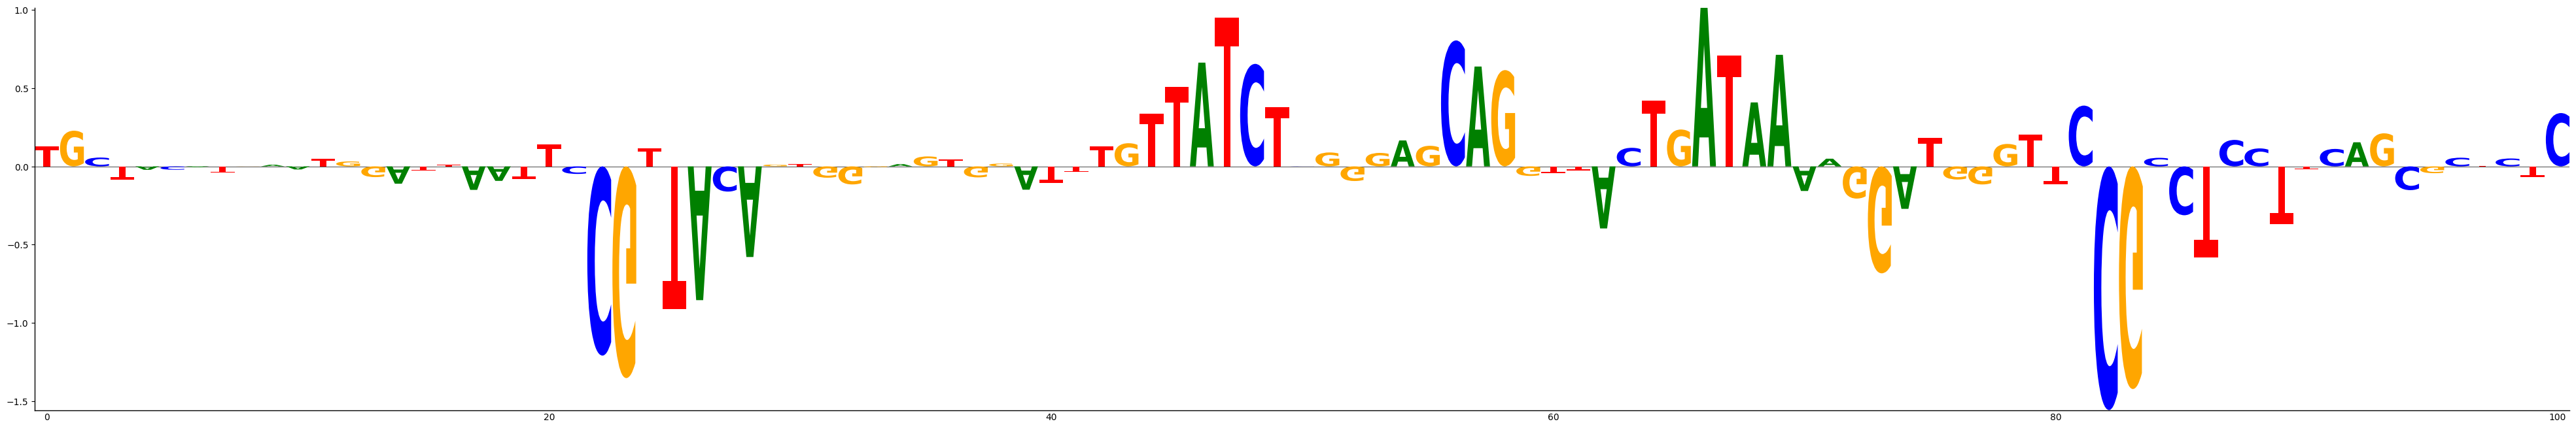

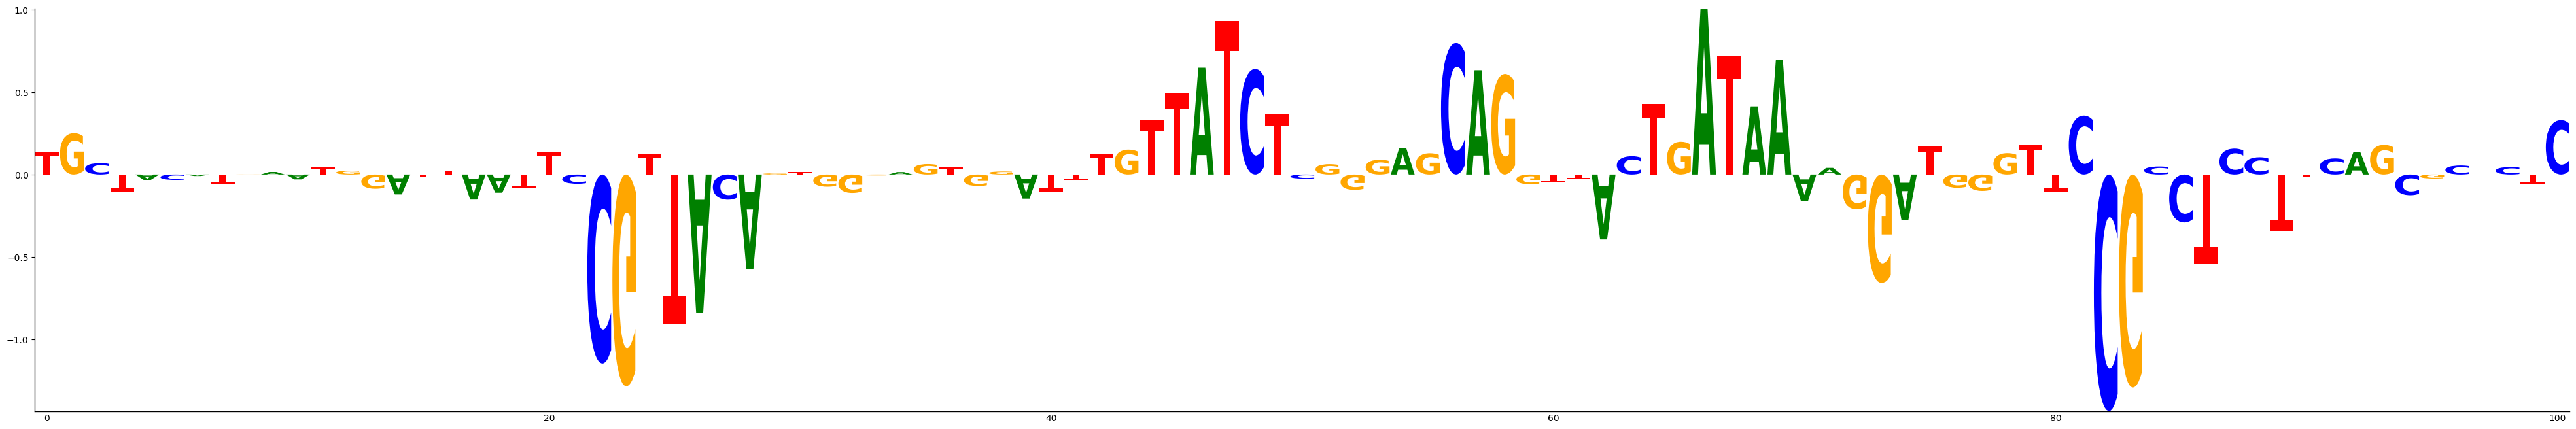

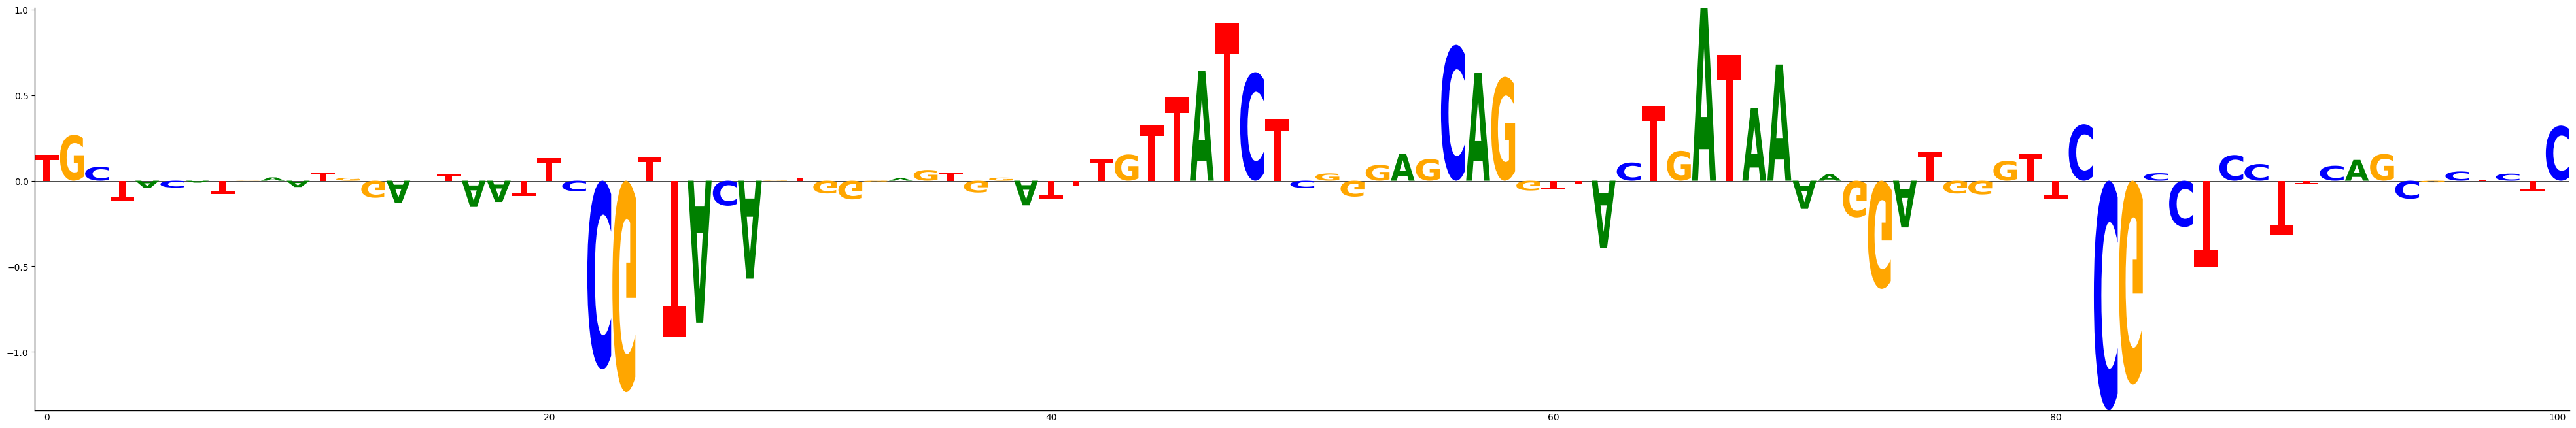

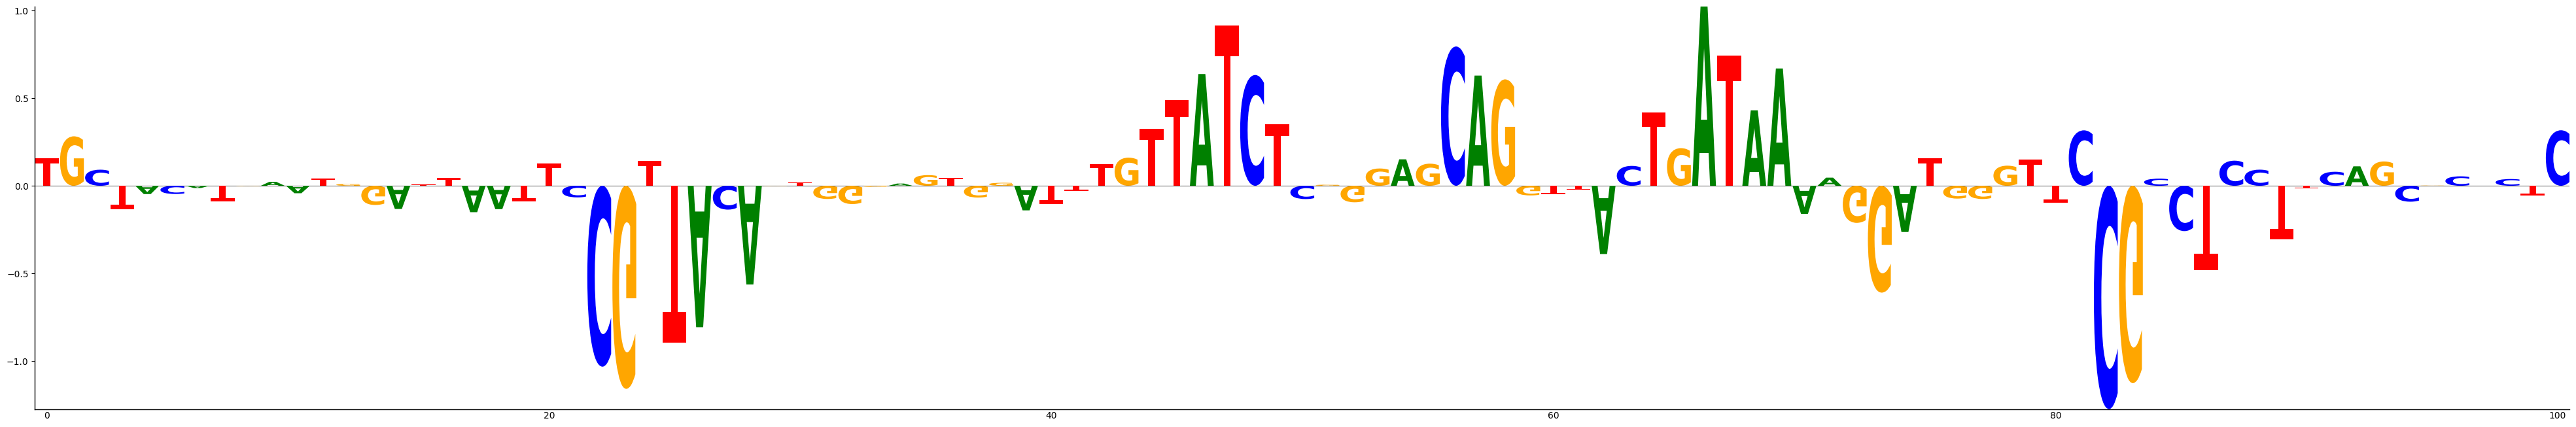

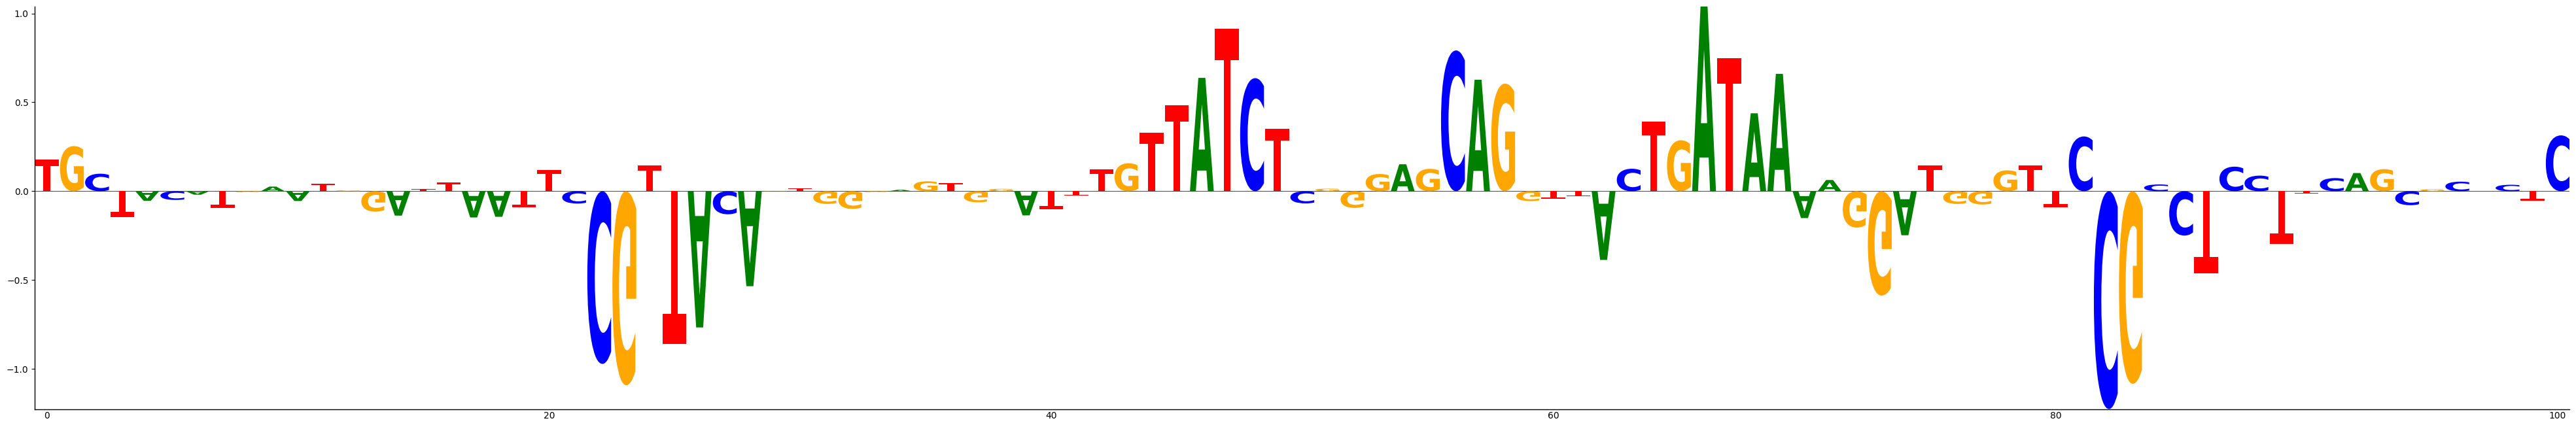

In [9]:
print("ShiftSmoothed Gradients")
shiftsmooth_crp_df_logo = create_logo(attr_shiftsmooth[:,mask], figsize=[50, 8], scale_data=scale_data)
for attr_shiftsmooth2, i in attr_shiftsmooths:
    print(f"ShiftSmoothed Gradients (Shifted {i})")
    shiftsmooth_crp_df_logo = create_logo(attr_shiftsmooth2[:,mask], figsize=[50, 8], scale_data=scale_data)



---

MoE Vanilla Gradients (Expert 0)
MoE Vanilla Gradients (Expert 1)
MoE Vanilla Gradients (Expert 2)


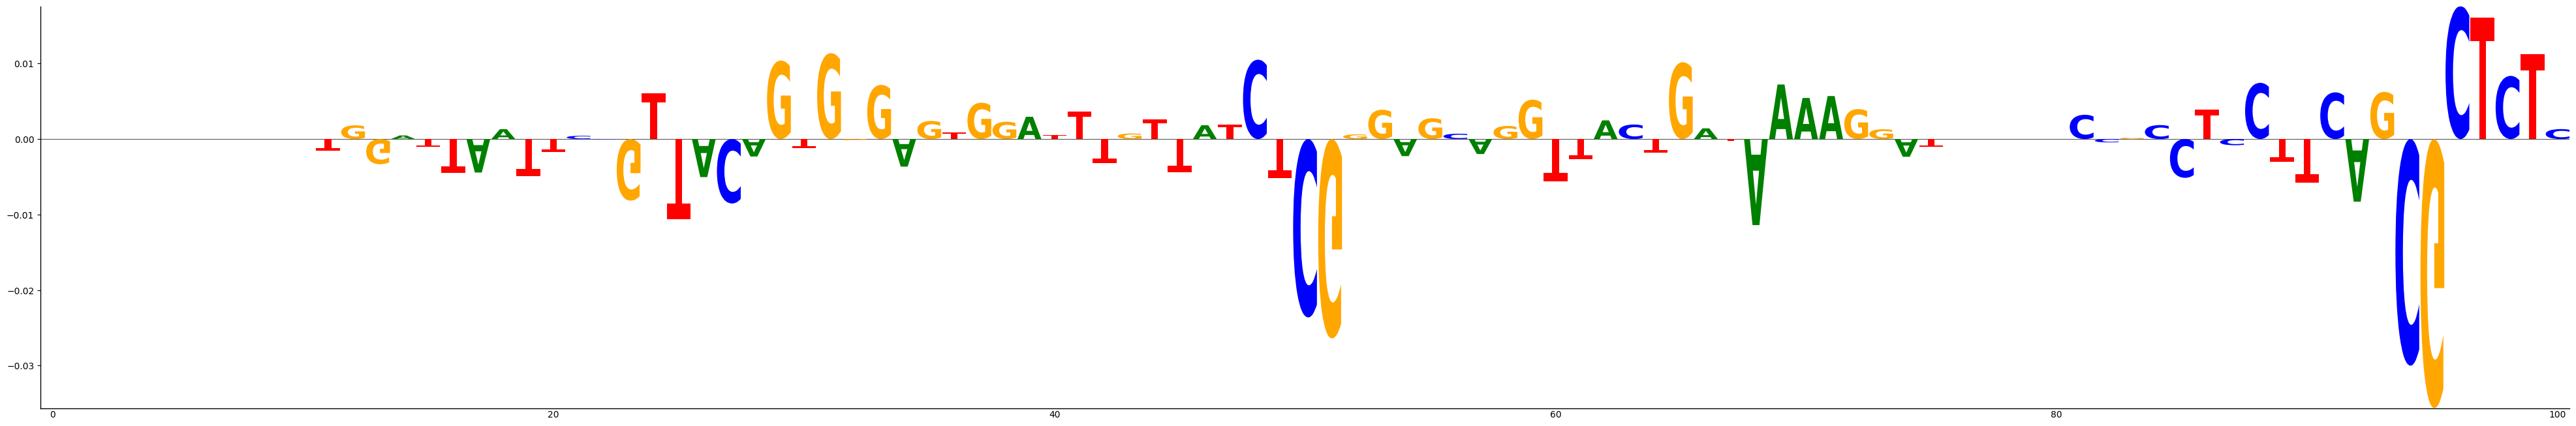

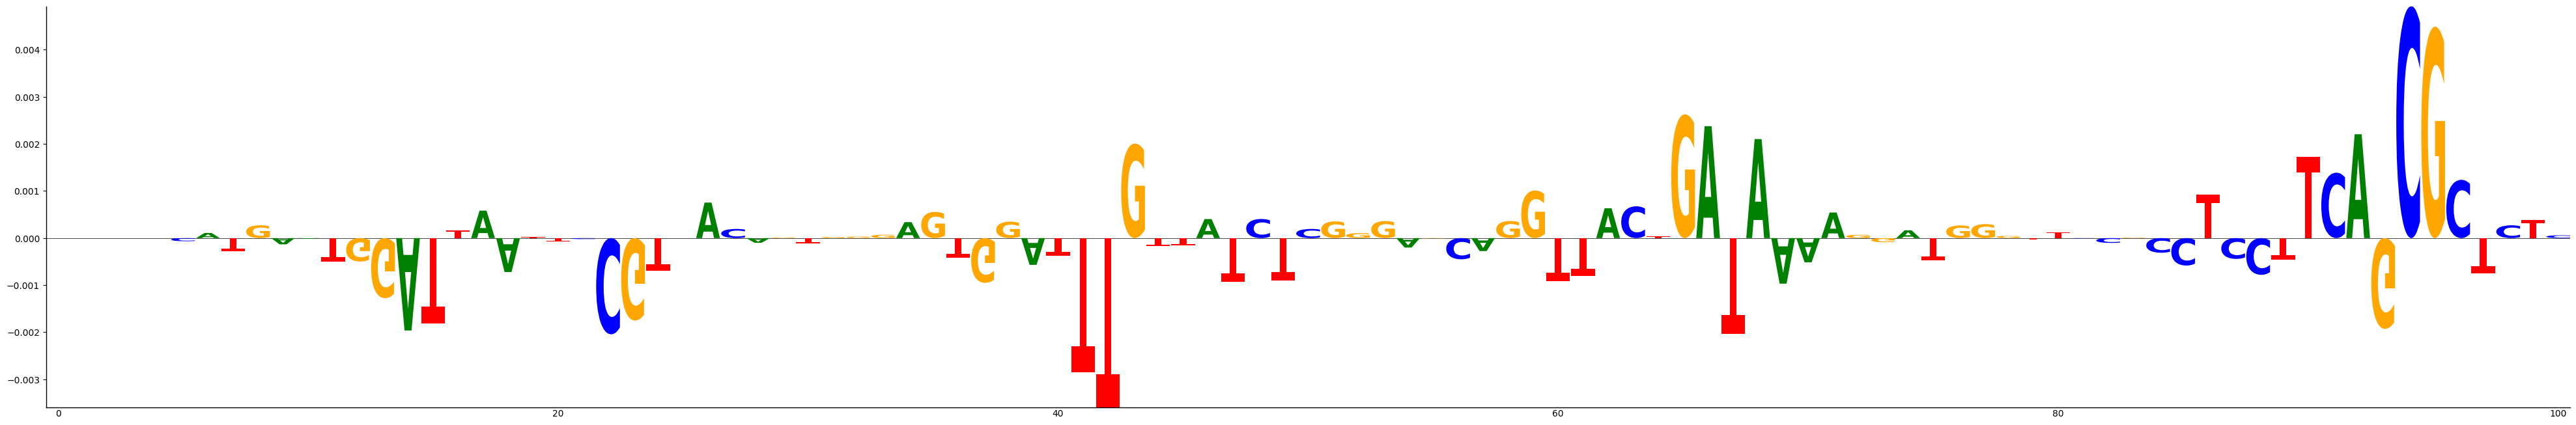

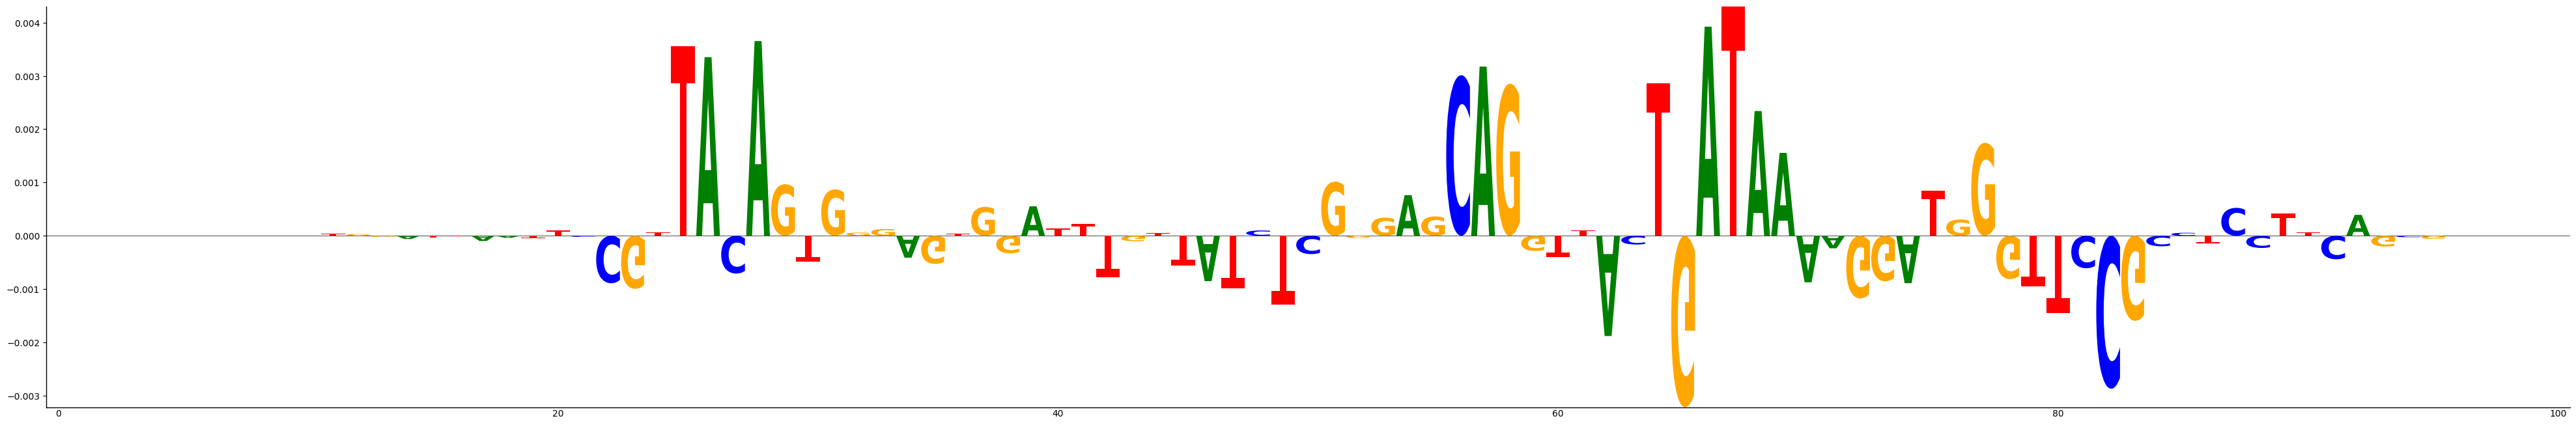

In [10]:

for i, moe_grad_ in enumerate(moe_grads_separate):
    print(f"MoE Vanilla Gradients (Expert {i})")
    moe_crp_df_logo = create_logo(moe_grad_[:,mask], figsize=[50, 8], scale_data=scale_data)


MoE Vanilla Gradients


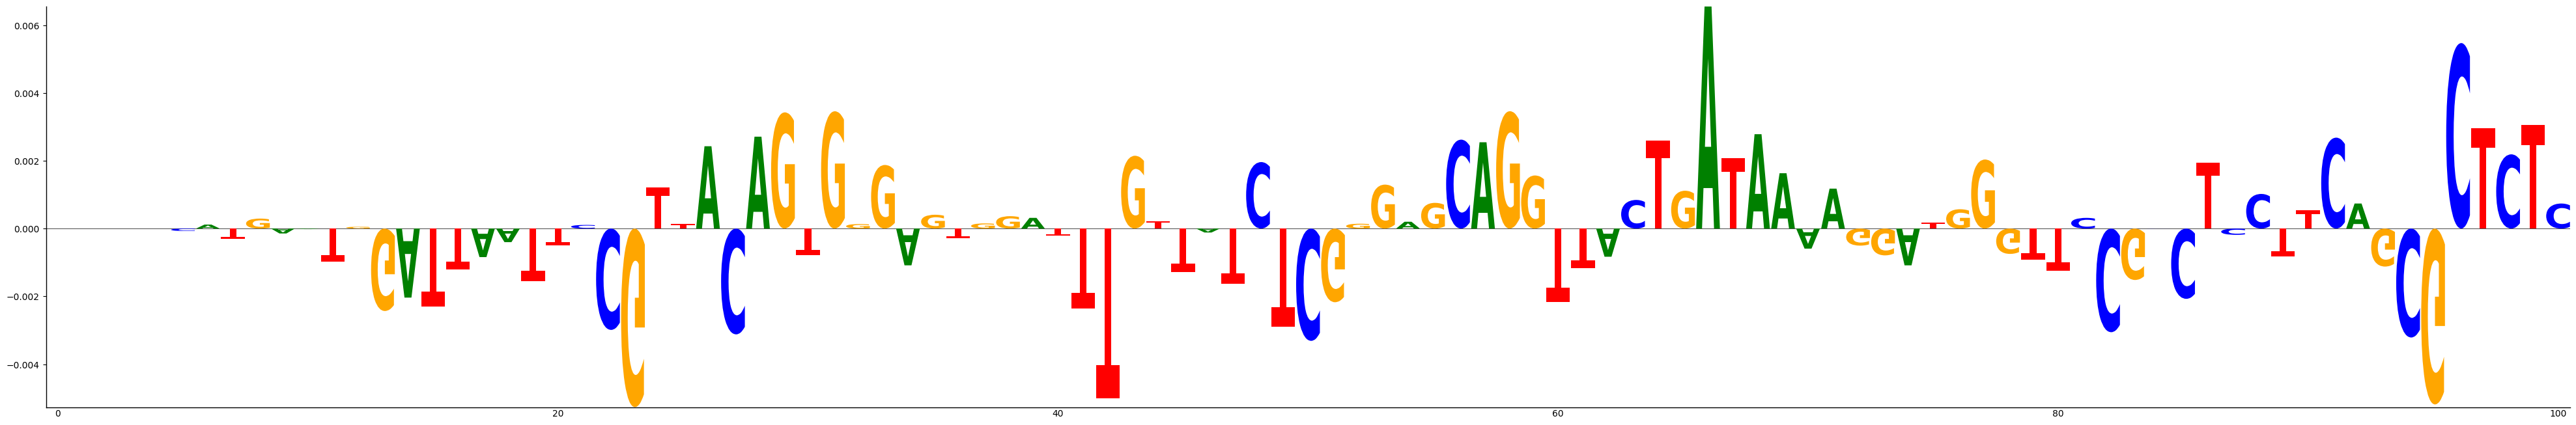

In [11]:
print("MoE Vanilla Gradients")
moe_crp_df_logo = create_logo(moe_grad[:,mask], figsize=[50, 8], scale_data=scale_data)
# print("MoE 2 Vanilla Gradients")
# moe_crp_df_logo = create_logo(moe_grad_, figsize=[50, 8], scale_data=scale_data)


MoE ShiftSmoothed Gradients (Shifted 2)
MoE ShiftSmoothed Gradients (Shifted 5)
MoE ShiftSmoothed Gradients (Shifted 8)
MoE ShiftSmoothed Gradients (Shifted 11)
MoE ShiftSmoothed Gradients (Shifted 14)
MoE ShiftSmoothed Gradients (Shifted 17)
MoE ShiftSmoothed Gradients (Shifted 20)
MoE ShiftSmoothed Gradients (Shifted 23)
MoE ShiftSmoothed Gradients (Shifted 26)
MoE ShiftSmoothed Gradients (Shifted 29)


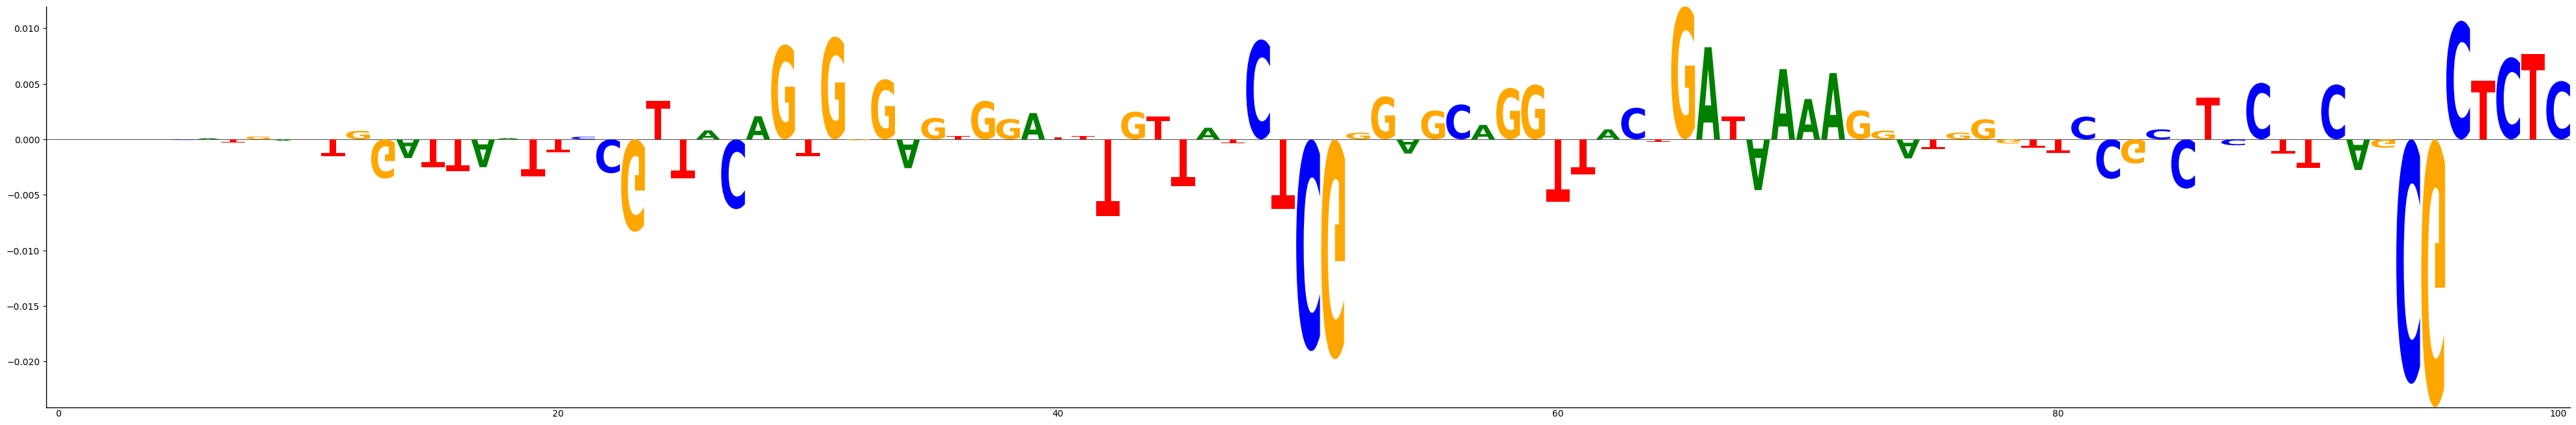

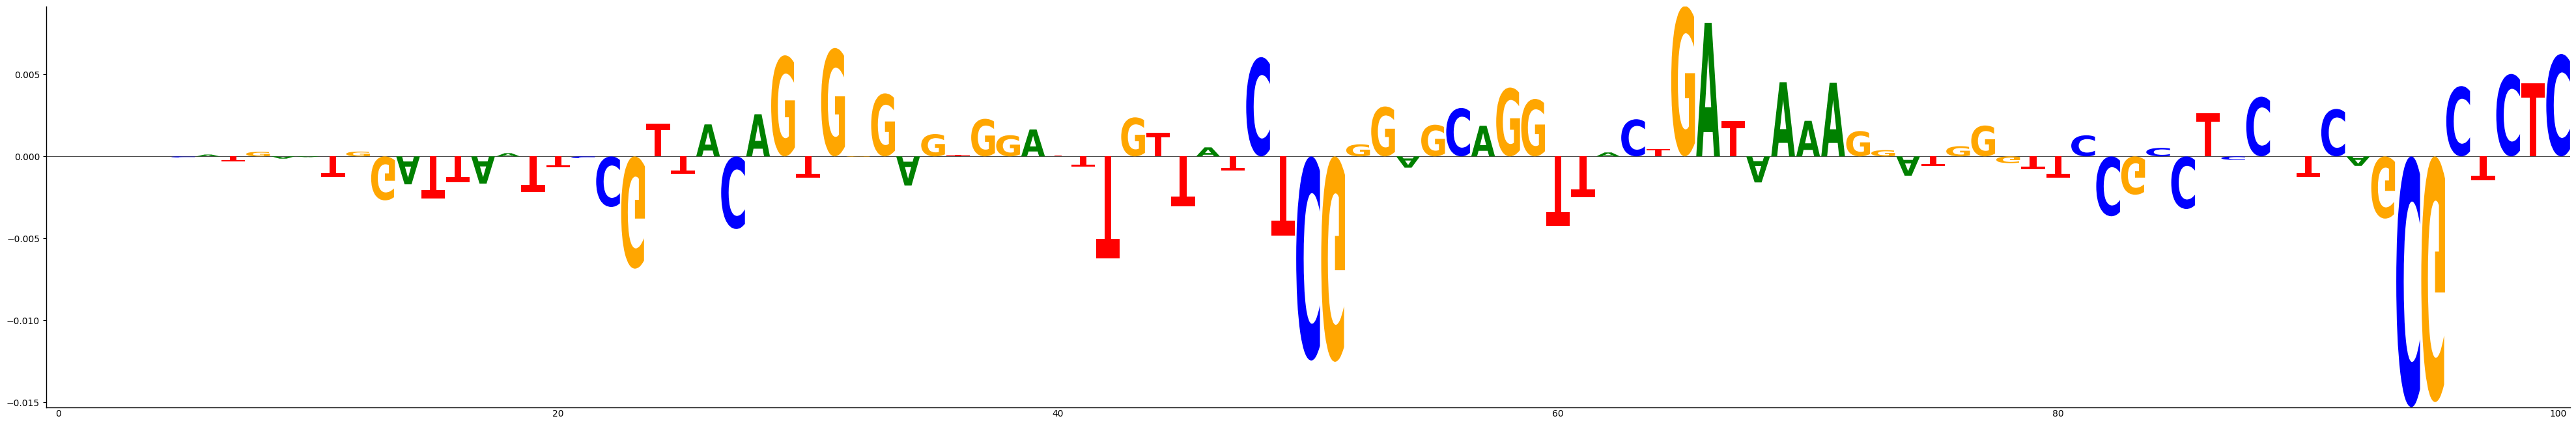

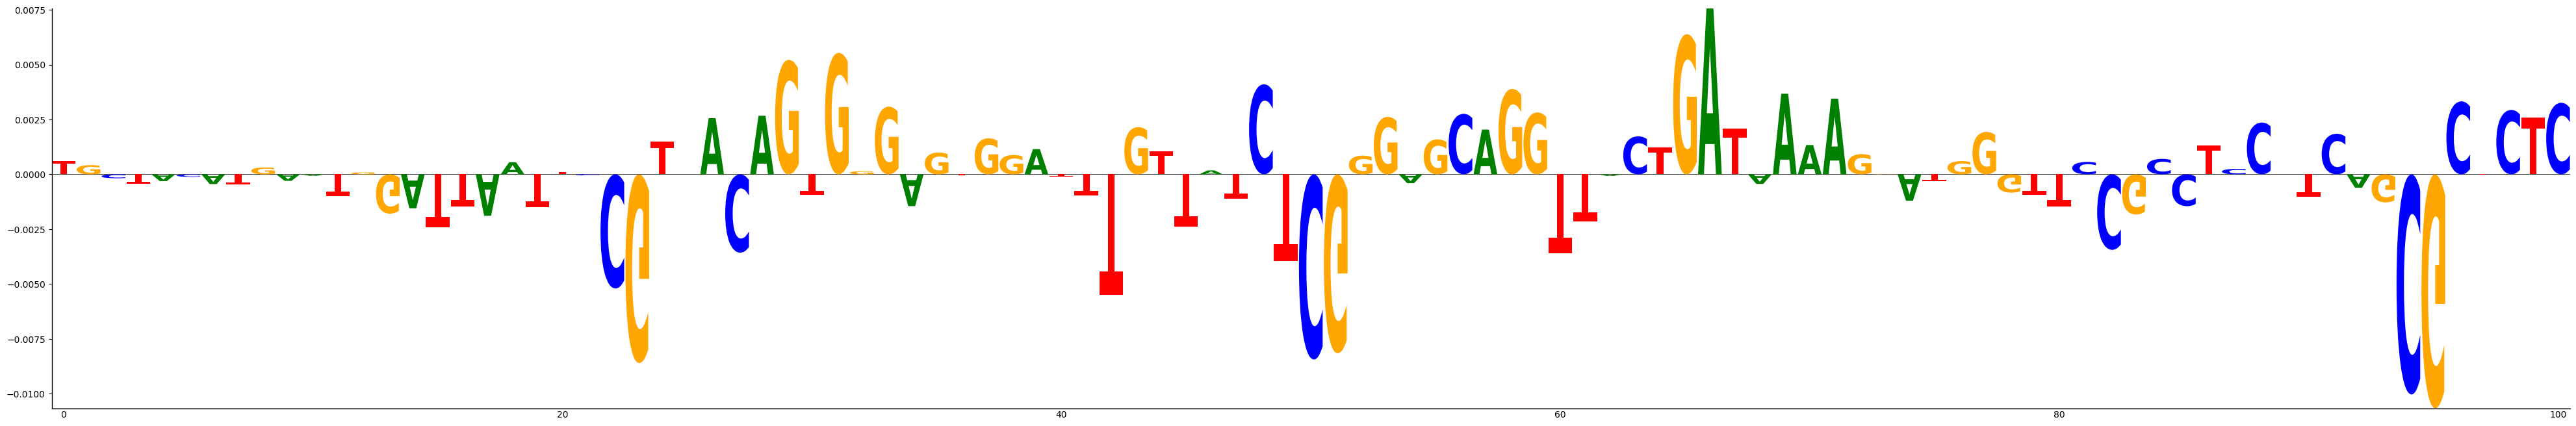

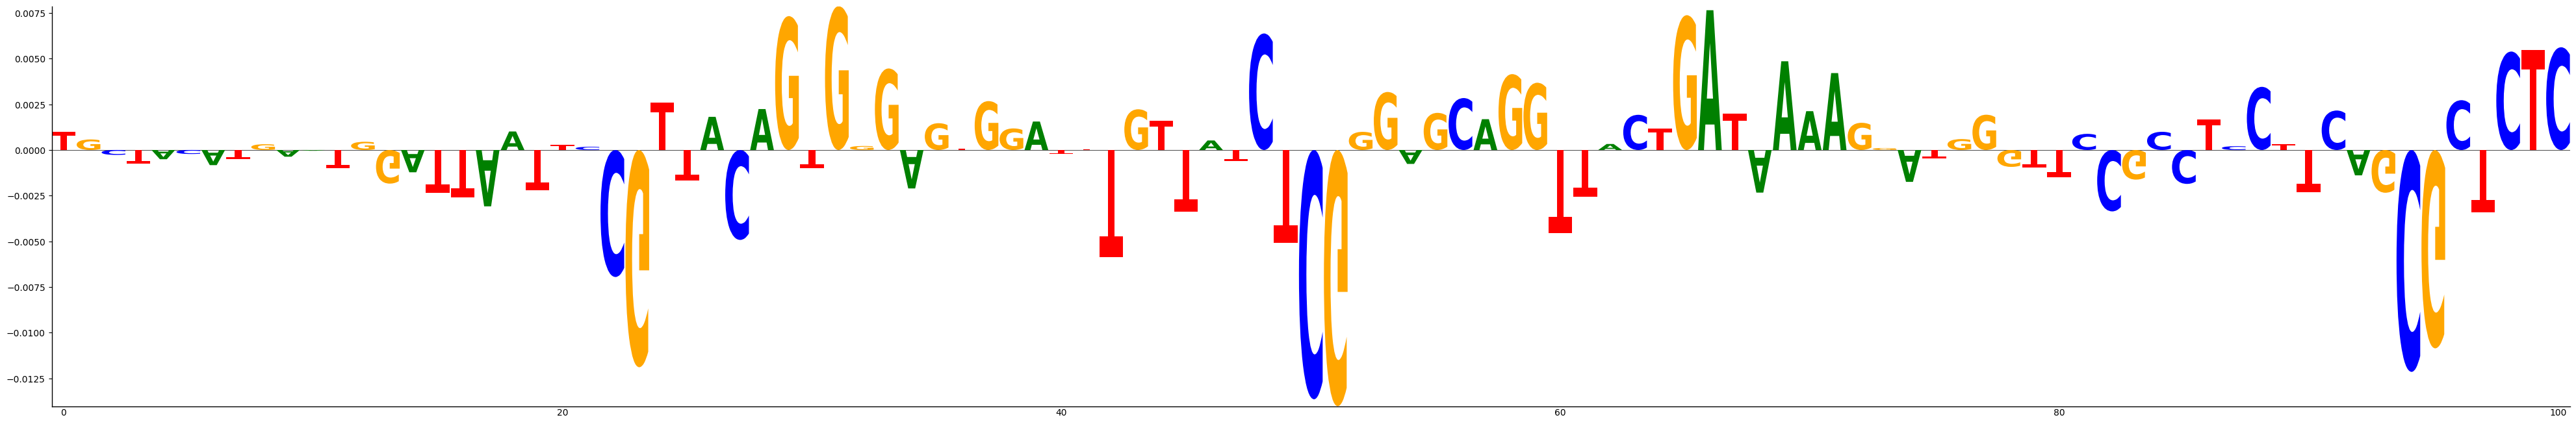

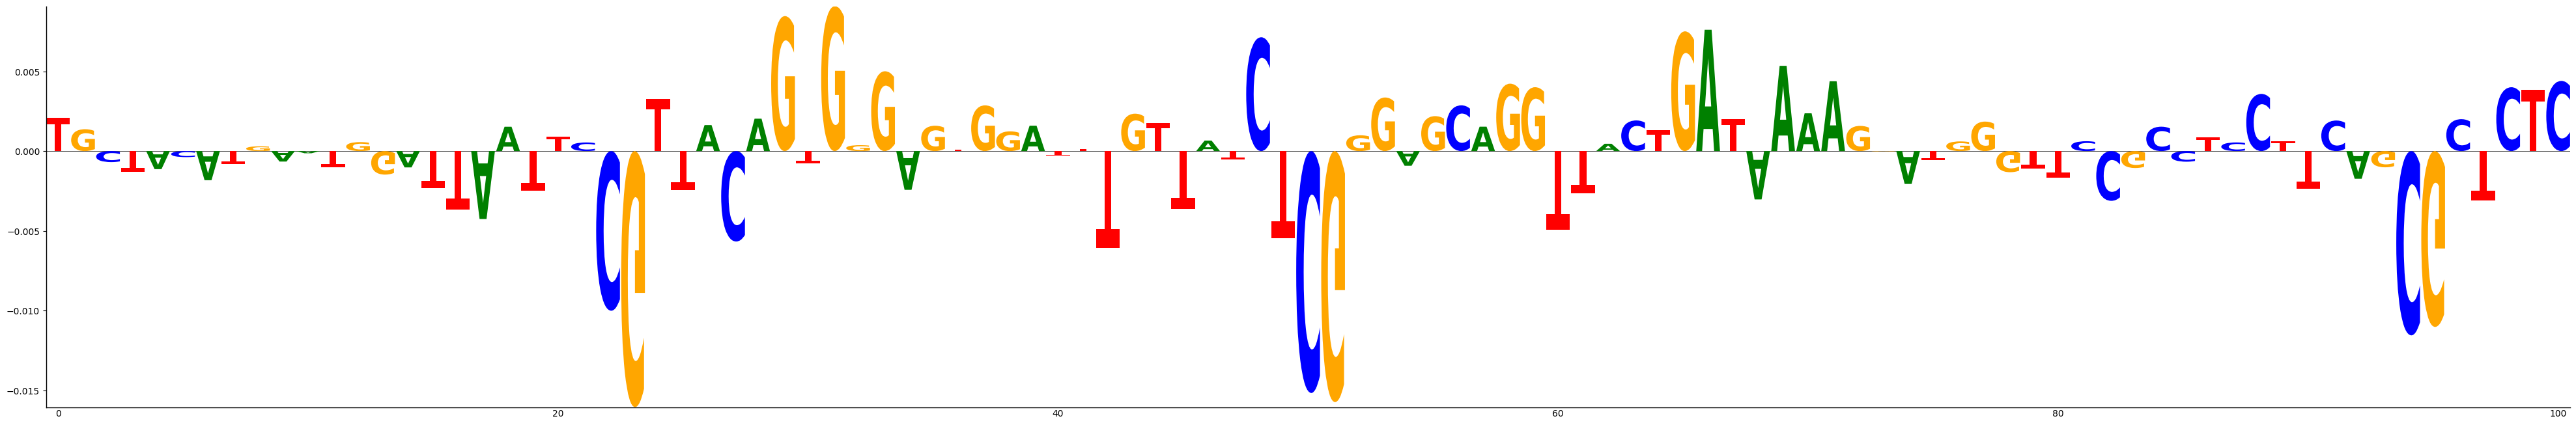

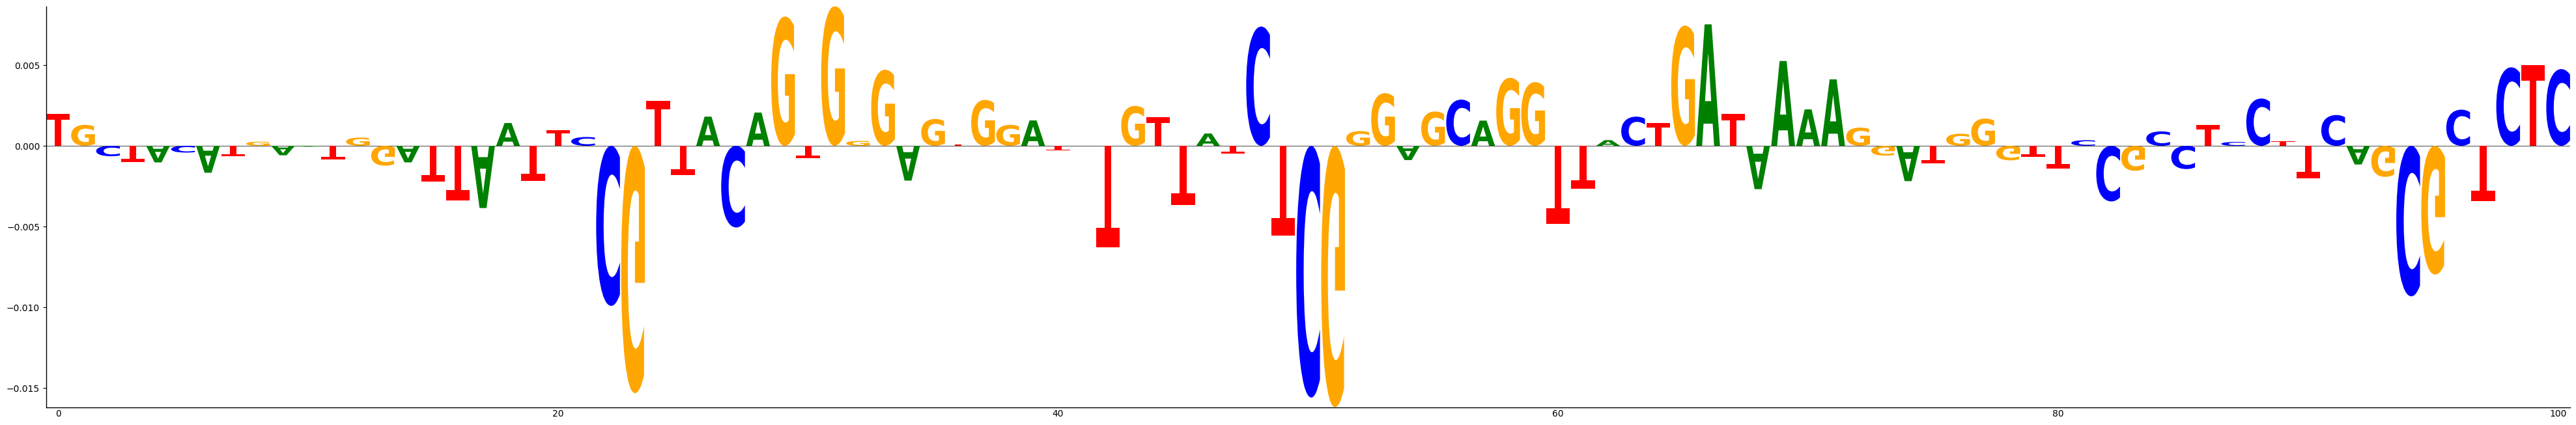

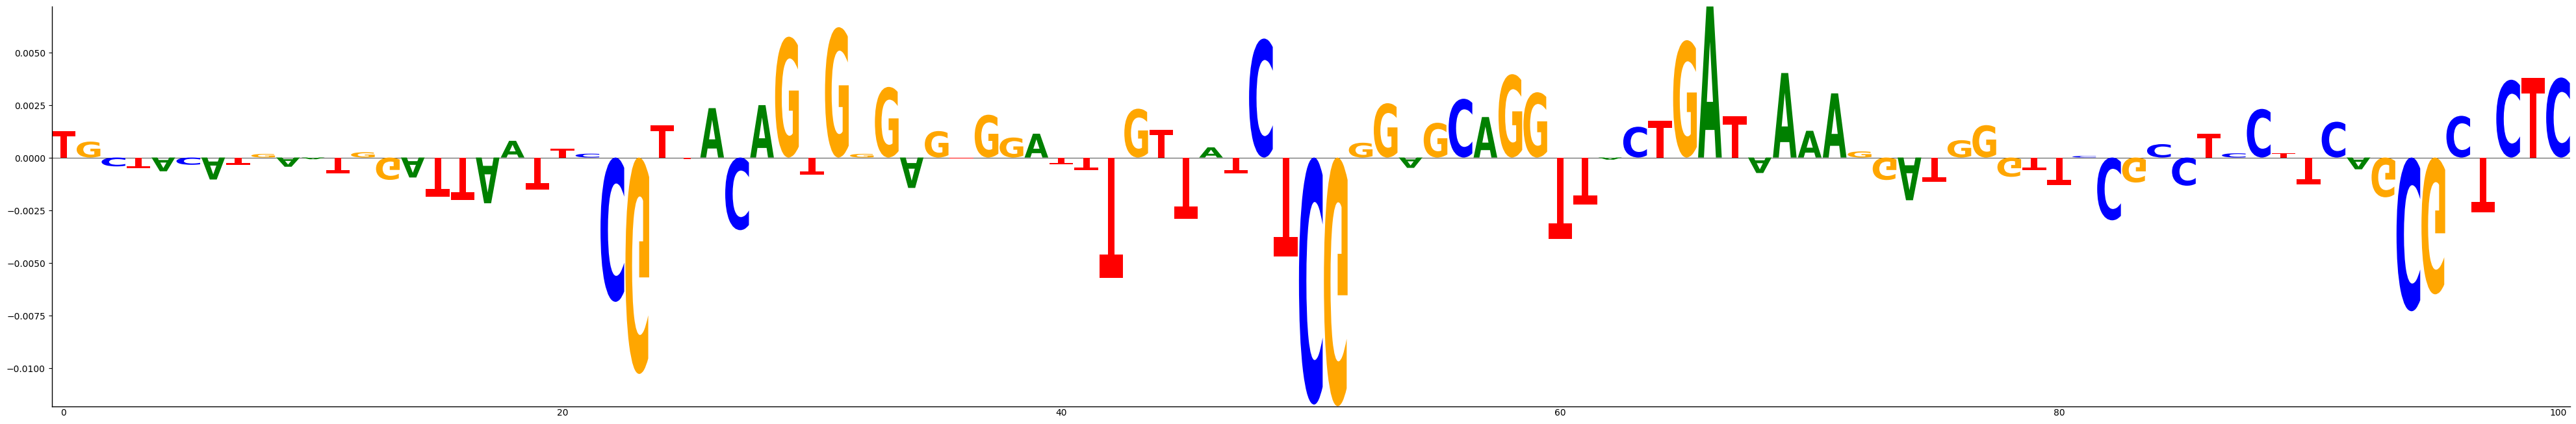

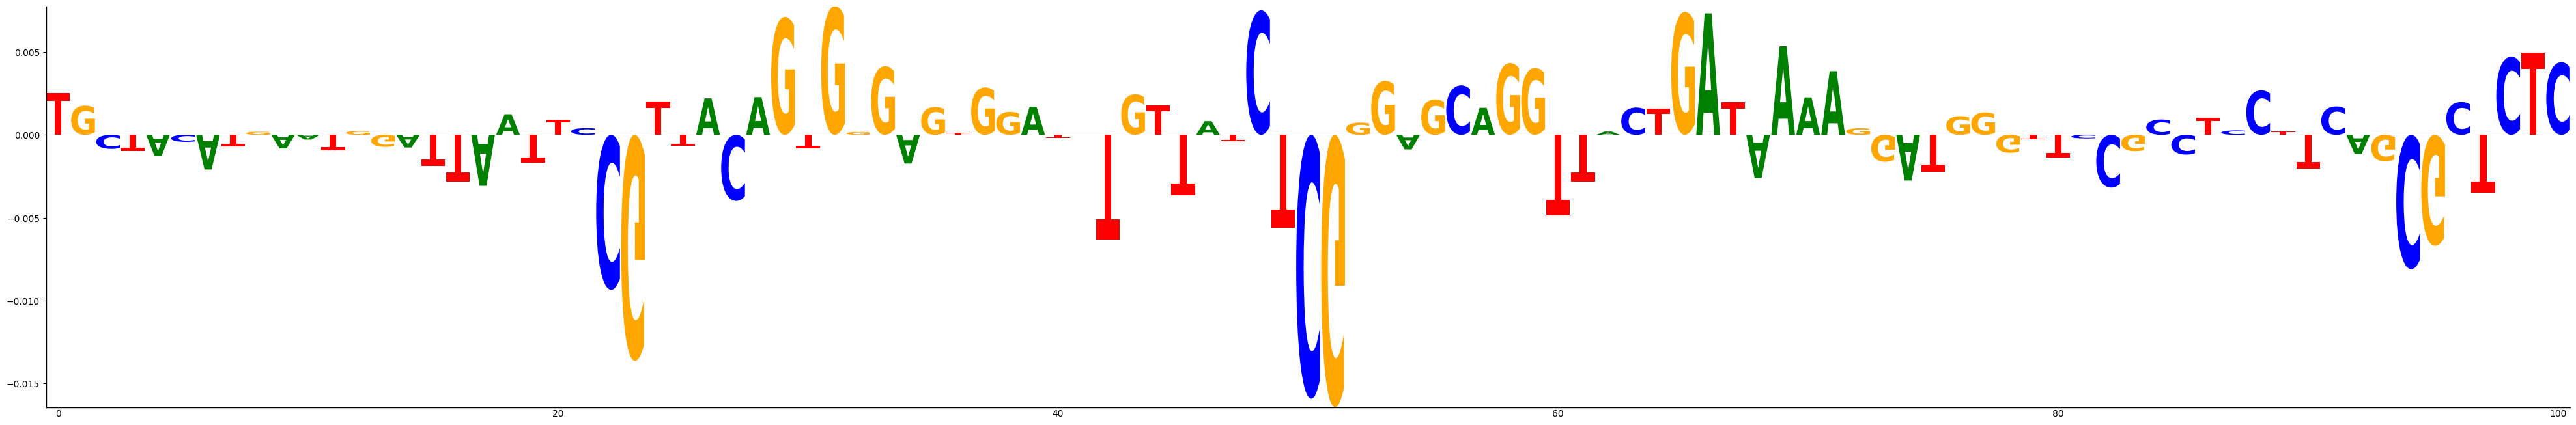

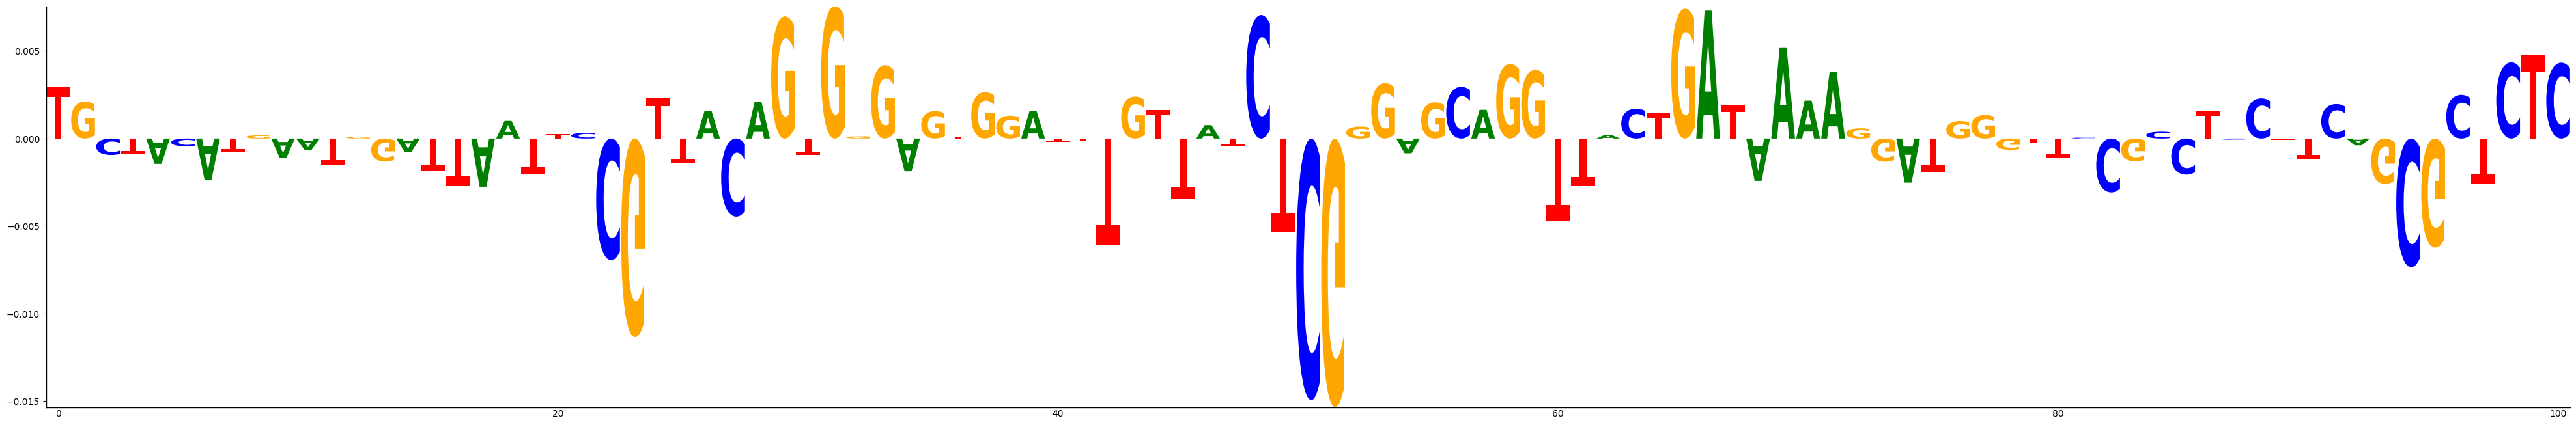

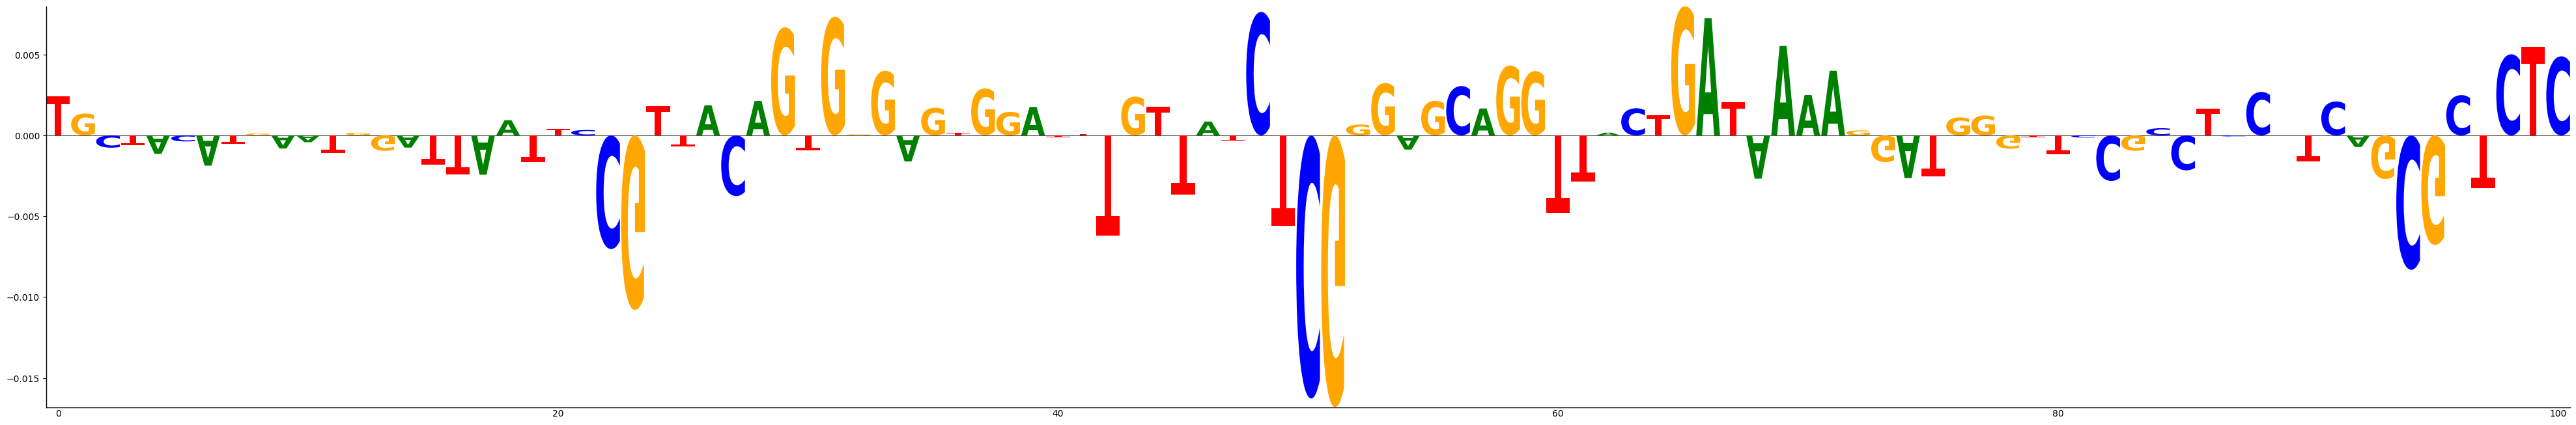

In [12]:
for moe_shiftsmooth, i in moe_shiftsmooths:
    print(f"MoE ShiftSmoothed Gradients (Shifted {i})")
    shiftsmooth_moe_df_logo = create_logo(moe_shiftsmooth[:,mask], figsize=[50, 8], scale_data=scale_data)

DeepLIFT


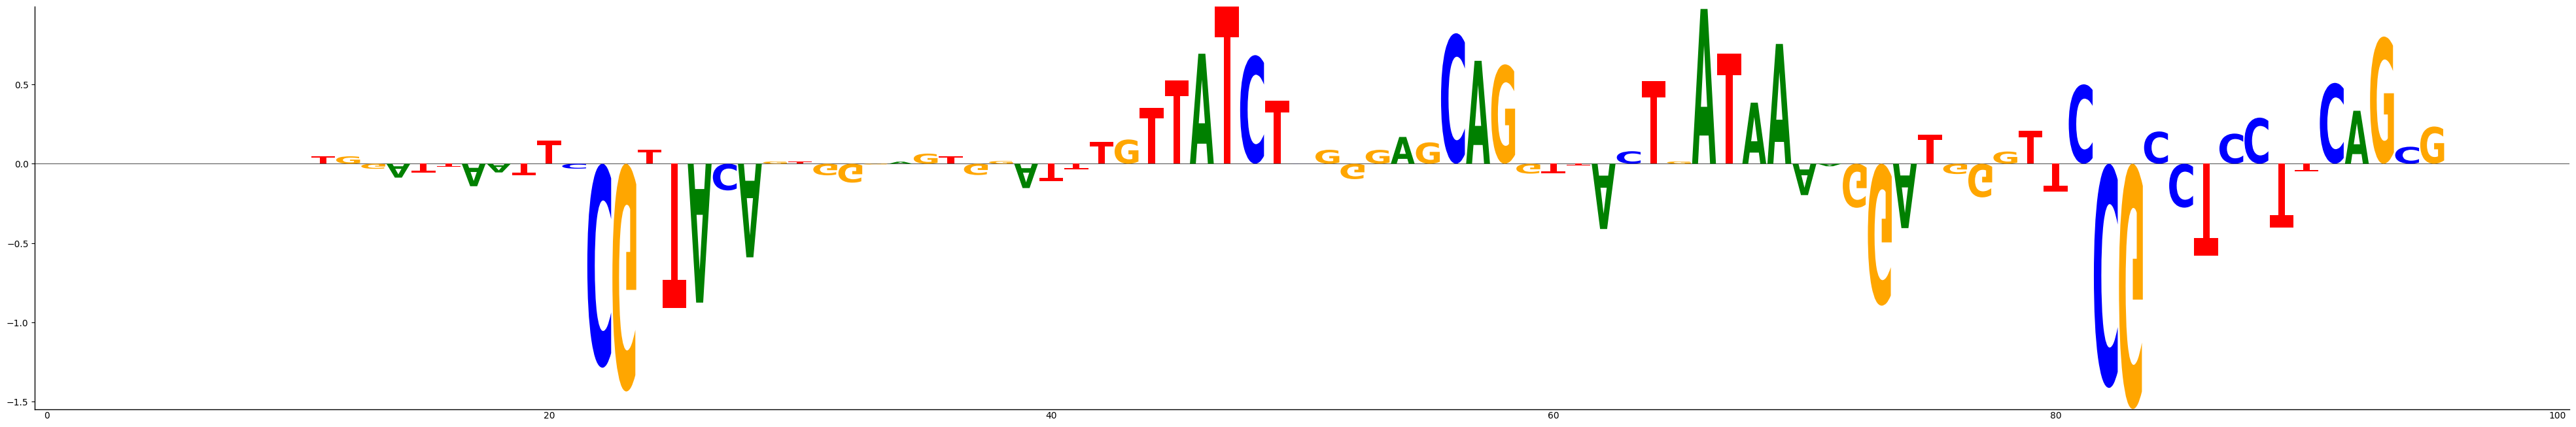

In [13]:
print("DeepLIFT")
dl_crp_df_logo = create_logo(attr_dl[:,mask], figsize=[50, 8], scale_data=scale_data)